In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def gen_data():
    bins = [np.linspace(-7,7,41)]*2
    _ed = np.linspace(-7,7,41)
    _ct = _ed[:-1] + np.diff(_ed)/2
    grid = np.meshgrid(*[_ct]*2, indexing='ij')

    
    K = 2
    centers = np.random.uniform(-6,6, size = (K, 2))
    X = np.concatenate([np.random.multivariate_normal(cc,0.2*np.eye(2), size = (1000,)) for cc in centers])
    c,_,_= np.histogram2d(X[:,0], X[:,1], bins = bins)
    c = np.log(c + 1e-2)
    c = np.stack([grid[0],grid[1],1-grid[0],1-grid[1],c])
    return torch.FloatTensor(c)[None,:], torch.FloatTensor(centers)[None,:]

def make_batch(
        Nbatch = 34,
        data_mean = torch.FloatTensor([0,0,0,0,3]),
        data_std = torch.FloatTensor([1,1,1,1,1])
    ):
    batch = [gen_data() for i in range(Nbatch)]
    data = torch.concatenate([b[0] for b in batch])
    trgt = torch.concatenate([b[1] for b in batch])
    
    bkgtrgt = -3*torch.ones(Nbatch,1,2)
    return data, trgt
make_batch(123)[0].shape

torch.Size([123, 5, 40, 40])

In [3]:
class TrivialSlotEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 2
                
        self.hidden_dim = 4
        self.encoder1 = torch.nn.Sequential(
            torch.nn.Conv2d(5,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
        )
        self.encoder2 = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(40*40*self.hidden_dim,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,self.latent_dim)
        )   
        
    def forward(self, data):
        encoded_data = self.encoder1(data)
        positions = self.encoder2(encoded_data)
        positions = positions.unsqueeze(1)
        return positions

In [4]:
class SlotAttentionEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.k_slots = 3
        self.latent_dim = 32
        self.hidden_dim = 32
        self.query_dim = 32
        self.slot_dim = 32
        self.n_iter = 1

        self.queryN = torch.nn.LayerNorm(self.query_dim)
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.updateN = torch.nn.LayerNorm(self.query_dim)

        self.toK = torch.nn.Linear(self.hidden_dim,self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim,self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(5,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
        )   
        
        self.final = torch.nn.Sequential(
            torch.nn.Linear(self.query_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,self.slot_dim)
        )

        self.updateff = torch.nn.Sequential(
            torch.nn.Linear(self.query_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,self.query_dim)
        )
        
    def init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim)
        
        mu = torch.zeros(1,1,self.query_dim)
        logsigma = torch.zeros(1,1,self.query_dim)
        
        return mu + noise*logsigma.exp()


    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        att = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) * 10
        att = torch.nn.functional.softmax(att, dim = 1)

        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        encoded_data = torch.permute(encoded_data,(0,2,3,1))
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)        
        vals = self.toV(encoded_data)
        extracted = torch.einsum('bsd,bde->bse',wts,vals)
        
        extracted = self.gru(
            extracted.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return extracted.reshape(queries.shape)
        
    def forward(self, data):
        Nbatch = data.shape[0]
        queries = self.init_slots(Nbatch)
        encoded_data = self.encoder(data)
        queries = self.iterate(queries, encoded_data)
        queries = self.iterate(queries, encoded_data)
        positions = self.final(queries)
        return positions,queries
        
SlotAttentionEncoder()(torch.randn(123,5,40,40))[0].shape

torch.Size([123, 3, 32])

In [5]:
TrivialSlotEncoder()(torch.randn(123,5,40,40)).shape

torch.Size([123, 1, 2])

In [6]:
class AttModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 32

        self.encoder = SlotAttentionEncoder()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,40*40),
            torch.nn.Unflatten(-1,(40,40))
        )
        

    def forward(self, data):
        Nbatch, *_ = data.shape
        positions,queries = self.encoder(data)
        decoded = self.decoder(positions)
        reco = decoded.sum(dim = 1)
        return reco,queries,decoded

AttModel().encoder(make_batch(123)[0])[0].shape

torch.Size([123, 3, 32])

In [7]:
def plotit(batchidx, model, data, losses):
    with torch.no_grad():
        model.eval()
        pred,queries,decoded = model(data)
        encoded_data = model.encoder.encoder(data)
        encoded_data = torch.permute(encoded_data,(0,2,3,1))
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = model.encoder.dataN(encoded_data)
        att,wts = model.encoder.attention_and_weights(queries,encoded_data)
#         print(wts.sum(dim=-1).max(),'max')
        att = att.reshape(len(att),3,40,40)
        wts = wts.reshape(len(att),3,40,40)
        
        crap = model.decoder(torch.randn(2,model.encoder.k_slots,model.encoder.slot_dim))
        
    f,axarr = plt.subplots(3,6)
    ax = axarr[0,0]
    ax.plot(losses)
    ax.set_yscale('log')
    ax.axis('off')
    ax = axarr[0,1]
    ax.pcolormesh(data[batchidx,-1], vmin = -3, vmax = 3)
    ax.axis('off')
    ax = axarr[0,2]
    ax.pcolormesh(pred[batchidx], vmin = -3, vmax = 3)
    ax.axis('off')
    for i in range(3):
        ax = axarr[0,3+i]
        ax.pcolormesh(att[batchidx,i], vmin = 0, vmax = 1)
        ax.axis('off')
    for i in range(3):
        ax = axarr[1,3+i]
        print(wts.min(),wts.max(),'>>><<')
        ax.pcolormesh(wts[batchidx,i], vmin = 0, vmax = .001)
        ax.axis('off')
    for i in range(3):
        ax = axarr[1,i]
        ax.axis('off')
        ax = axarr[2,i]
        ax.axis('off')
    ax = axarr[1,0]
    ax.pcolormesh(crap[batchidx,0])

    ax = axarr[1,2]
    ax.pcolormesh(decoded.sum(dim=1)[batchidx], vmin = -3, vmax = 3)
    for i in range(3):
        ax = axarr[2,3+i]
        ax.pcolormesh(decoded[batchidx,i], vmin = -3, vmax = 3)
        ax.axis('off')
    f.set_size_inches(6,3)
    plt.show()    

def train(model, Ntrain = 5000):
    opt = torch.optim.Adam(model.parameters(), 3e-4)
    model.train()
    losses = []
    for i in range(Ntrain):
        
        warmup_steps = 5000
        learning_rate = 3e-4
        if i < warmup_steps:
            learning_rate = learning_rate * (i / warmup_steps)
        else:
            learning_rate = learning_rate
        opt.param_groups[0]['lr'] = learning_rate

        
        data, trgt = make_batch(4)
        pred,*_ = model(data)
        loss = torch.nn.functional.mse_loss(
            data[:,-1,...],
            pred
        )
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(loss))
        if i % 250 == 0:
            print('loss',i,loss,opt.param_groups[0]['lr'])
            plotit(0,model,data,losses)
            plotit(1,model,data,losses)

    model.eval()
    return model,losses

loss 0 tensor(0.9085, grad_fn=<MseLossBackward0>) 0.0
tensor(1.0000e-08) tensor(0.1556) >>><<
tensor(1.0000e-08) tensor(0.1556) >>><<
tensor(1.0000e-08) tensor(0.1556) >>><<


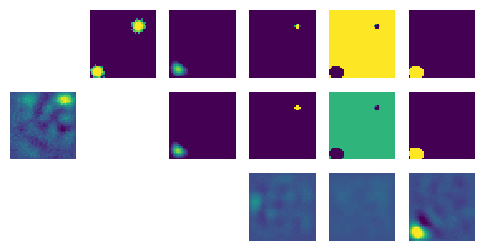

tensor(1.0000e-08) tensor(0.2239) >>><<
tensor(1.0000e-08) tensor(0.2239) >>><<
tensor(1.0000e-08) tensor(0.2239) >>><<


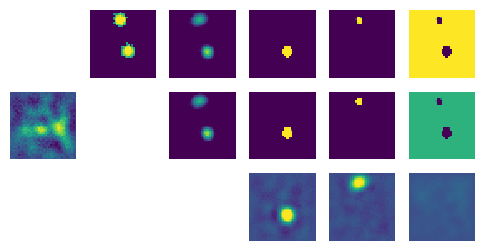

loss 250 tensor(1.0467, grad_fn=<MseLossBackward0>) 1.4999999999999999e-05
tensor(1.0000e-08) tensor(0.0557) >>><<
tensor(1.0000e-08) tensor(0.0557) >>><<
tensor(1.0000e-08) tensor(0.0557) >>><<


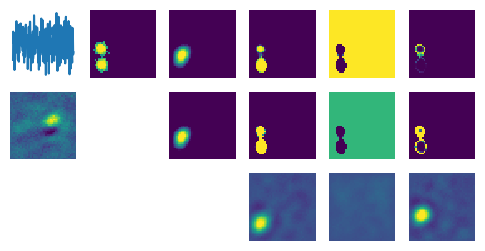

tensor(1.0000e-08) tensor(0.7735) >>><<
tensor(1.0000e-08) tensor(0.7735) >>><<
tensor(1.0000e-08) tensor(0.7735) >>><<


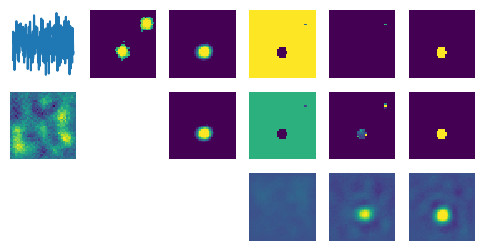

loss 500 tensor(1.2838, grad_fn=<MseLossBackward0>) 2.9999999999999997e-05
tensor(1.0000e-08) tensor(0.0975) >>><<
tensor(1.0000e-08) tensor(0.0975) >>><<
tensor(1.0000e-08) tensor(0.0975) >>><<


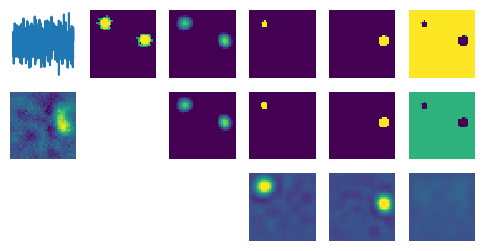

tensor(1.0000e-08) tensor(0.3029) >>><<
tensor(1.0000e-08) tensor(0.3029) >>><<
tensor(1.0000e-08) tensor(0.3029) >>><<


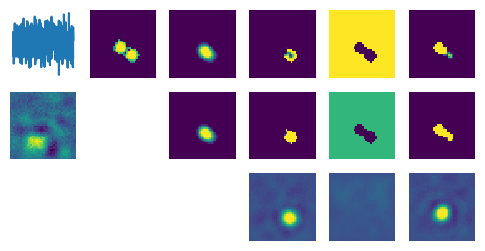

loss 750 tensor(1.2977, grad_fn=<MseLossBackward0>) 4.4999999999999996e-05
tensor(1.0000e-08) tensor(0.9738) >>><<
tensor(1.0000e-08) tensor(0.9738) >>><<
tensor(1.0000e-08) tensor(0.9738) >>><<


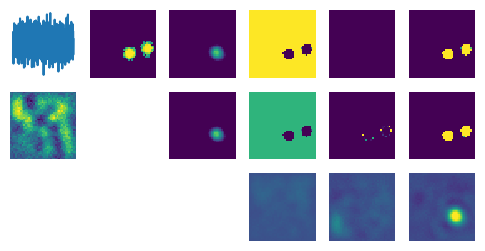

tensor(1.0000e-08) tensor(0.1940) >>><<
tensor(1.0000e-08) tensor(0.1940) >>><<
tensor(1.0000e-08) tensor(0.1940) >>><<


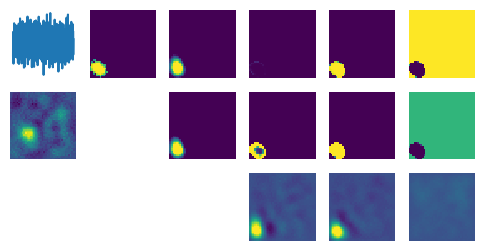

loss 1000 tensor(1.0064, grad_fn=<MseLossBackward0>) 5.9999999999999995e-05
tensor(1.0000e-08) tensor(0.0801) >>><<
tensor(1.0000e-08) tensor(0.0801) >>><<
tensor(1.0000e-08) tensor(0.0801) >>><<


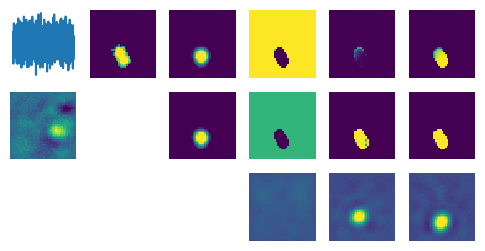

tensor(1.0000e-08) tensor(0.7951) >>><<
tensor(1.0000e-08) tensor(0.7951) >>><<
tensor(1.0000e-08) tensor(0.7951) >>><<


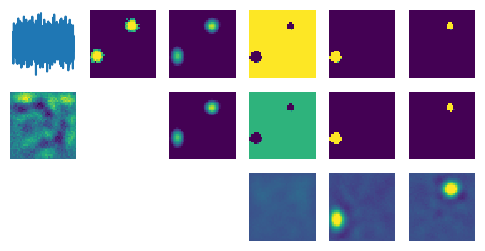

loss 1250 tensor(1.1898, grad_fn=<MseLossBackward0>) 7.5e-05
tensor(1.0000e-08) tensor(0.1821) >>><<
tensor(1.0000e-08) tensor(0.1821) >>><<
tensor(1.0000e-08) tensor(0.1821) >>><<


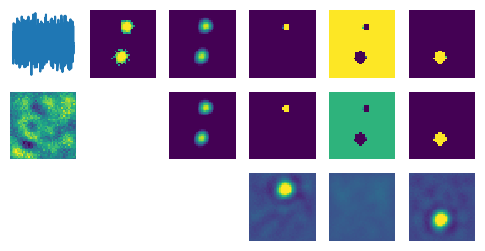

tensor(1.0000e-08) tensor(0.0838) >>><<
tensor(1.0000e-08) tensor(0.0838) >>><<
tensor(1.0000e-08) tensor(0.0838) >>><<


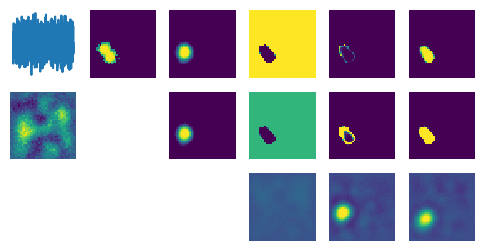

loss 1500 tensor(1.1990, grad_fn=<MseLossBackward0>) 8.999999999999999e-05
tensor(1.0000e-08) tensor(0.7113) >>><<
tensor(1.0000e-08) tensor(0.7113) >>><<
tensor(1.0000e-08) tensor(0.7113) >>><<


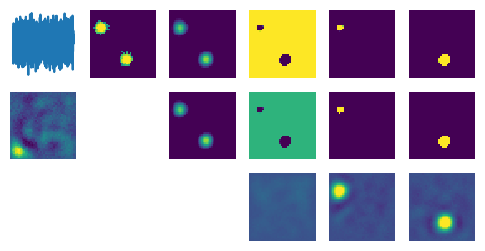

tensor(1.0000e-08) tensor(0.1632) >>><<
tensor(1.0000e-08) tensor(0.1632) >>><<
tensor(1.0000e-08) tensor(0.1632) >>><<


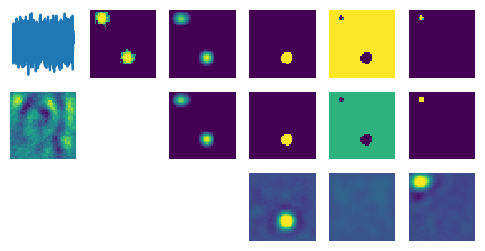

loss 1750 tensor(1.2957, grad_fn=<MseLossBackward0>) 0.00010499999999999999
tensor(1.0000e-08) tensor(0.9546) >>><<
tensor(1.0000e-08) tensor(0.9546) >>><<
tensor(1.0000e-08) tensor(0.9546) >>><<


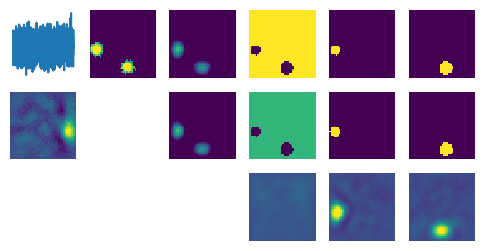

tensor(1.0000e-08) tensor(0.0614) >>><<
tensor(1.0000e-08) tensor(0.0614) >>><<
tensor(1.0000e-08) tensor(0.0614) >>><<


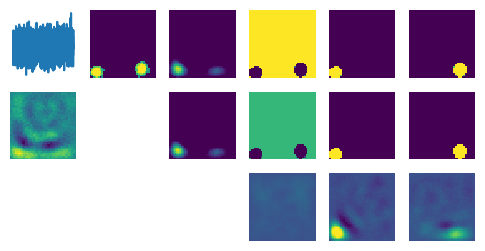

loss 2000 tensor(0.9861, grad_fn=<MseLossBackward0>) 0.00011999999999999999
tensor(1.0000e-08) tensor(0.2750) >>><<
tensor(1.0000e-08) tensor(0.2750) >>><<
tensor(1.0000e-08) tensor(0.2750) >>><<


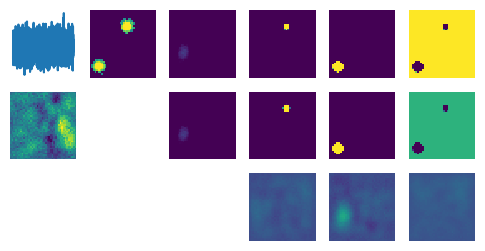

tensor(1.0000e-08) tensor(0.2409) >>><<
tensor(1.0000e-08) tensor(0.2409) >>><<
tensor(1.0000e-08) tensor(0.2409) >>><<


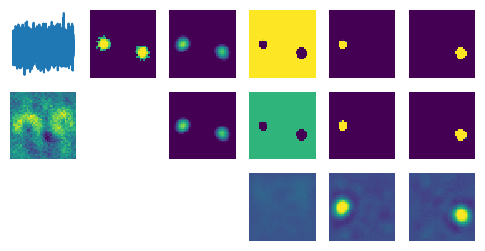

loss 2250 tensor(1.4182, grad_fn=<MseLossBackward0>) 0.000135
tensor(1.0000e-08) tensor(0.0489) >>><<
tensor(1.0000e-08) tensor(0.0489) >>><<
tensor(1.0000e-08) tensor(0.0489) >>><<


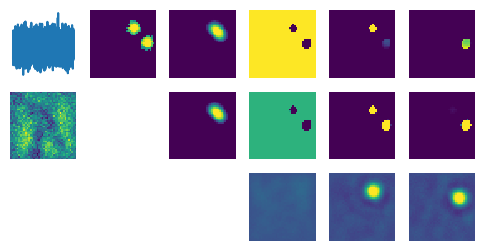

tensor(1.0000e-08) tensor(0.1004) >>><<
tensor(1.0000e-08) tensor(0.1004) >>><<
tensor(1.0000e-08) tensor(0.1004) >>><<


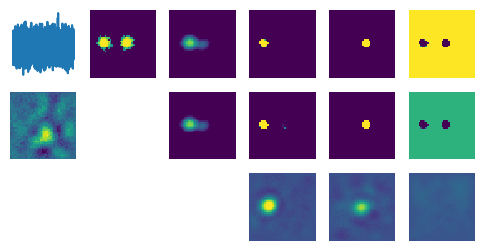

loss 2500 tensor(0.8723, grad_fn=<MseLossBackward0>) 0.00015
tensor(1.0000e-08) tensor(0.0907) >>><<
tensor(1.0000e-08) tensor(0.0907) >>><<
tensor(1.0000e-08) tensor(0.0907) >>><<


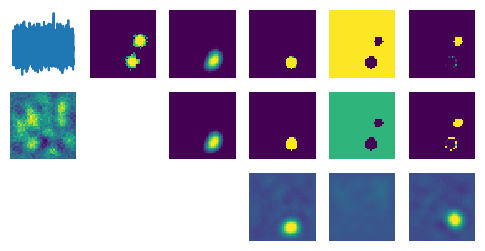

tensor(1.0000e-08) tensor(0.1161) >>><<
tensor(1.0000e-08) tensor(0.1161) >>><<
tensor(1.0000e-08) tensor(0.1161) >>><<


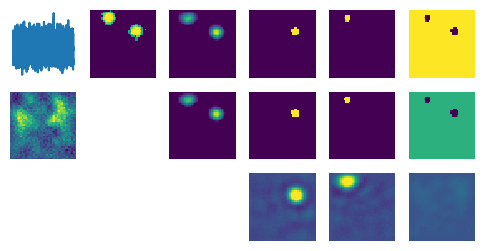

loss 2750 tensor(1.1212, grad_fn=<MseLossBackward0>) 0.000165
tensor(1.0000e-08) tensor(0.0833) >>><<
tensor(1.0000e-08) tensor(0.0833) >>><<
tensor(1.0000e-08) tensor(0.0833) >>><<


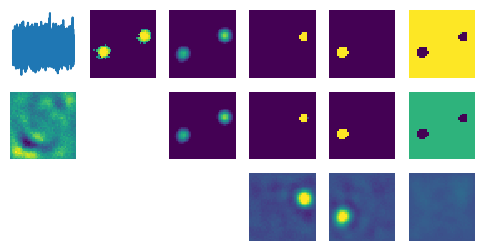

tensor(1.0000e-08) tensor(0.1429) >>><<
tensor(1.0000e-08) tensor(0.1429) >>><<
tensor(1.0000e-08) tensor(0.1429) >>><<


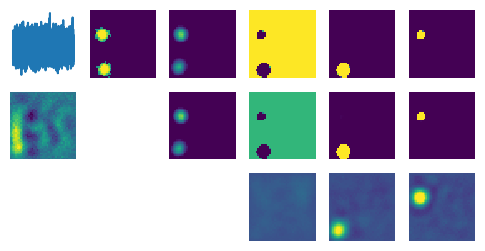

loss 3000 tensor(1.4860, grad_fn=<MseLossBackward0>) 0.00017999999999999998
tensor(1.0000e-08) tensor(0.0705) >>><<
tensor(1.0000e-08) tensor(0.0705) >>><<
tensor(1.0000e-08) tensor(0.0705) >>><<


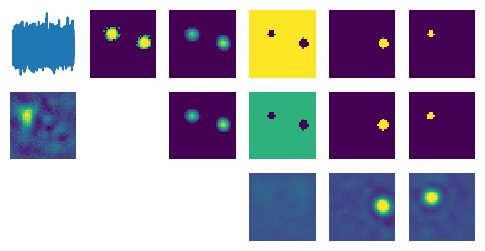

tensor(1.0000e-08) tensor(0.0977) >>><<
tensor(1.0000e-08) tensor(0.0977) >>><<
tensor(1.0000e-08) tensor(0.0977) >>><<


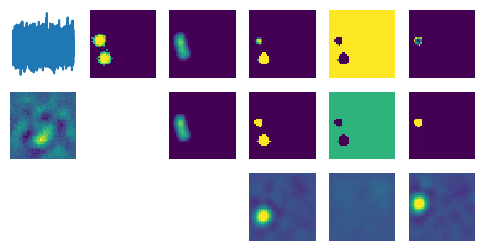

loss 3250 tensor(1.2124, grad_fn=<MseLossBackward0>) 0.000195
tensor(1.0000e-08) tensor(0.0656) >>><<
tensor(1.0000e-08) tensor(0.0656) >>><<
tensor(1.0000e-08) tensor(0.0656) >>><<


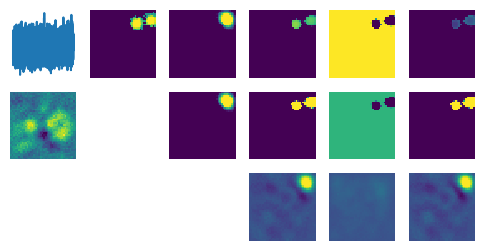

tensor(1.0000e-08) tensor(0.0768) >>><<
tensor(1.0000e-08) tensor(0.0768) >>><<
tensor(1.0000e-08) tensor(0.0768) >>><<


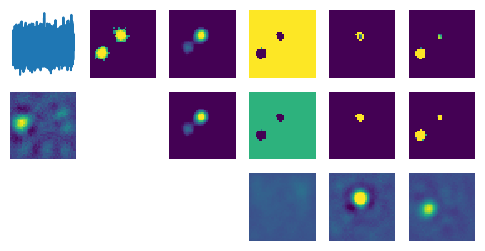

loss 3500 tensor(1.2431, grad_fn=<MseLossBackward0>) 0.00020999999999999998
tensor(1.0000e-08) tensor(0.0690) >>><<
tensor(1.0000e-08) tensor(0.0690) >>><<
tensor(1.0000e-08) tensor(0.0690) >>><<


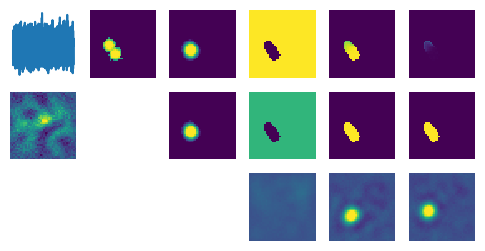

tensor(1.0000e-08) tensor(0.1267) >>><<
tensor(1.0000e-08) tensor(0.1267) >>><<
tensor(1.0000e-08) tensor(0.1267) >>><<


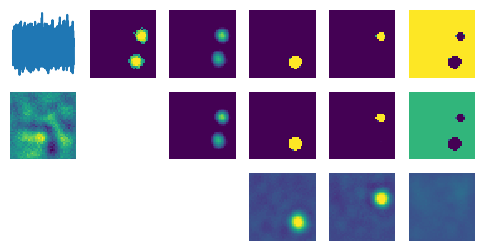

loss 3750 tensor(1.0093, grad_fn=<MseLossBackward0>) 0.000225
tensor(1.0000e-08) tensor(0.2672) >>><<
tensor(1.0000e-08) tensor(0.2672) >>><<
tensor(1.0000e-08) tensor(0.2672) >>><<


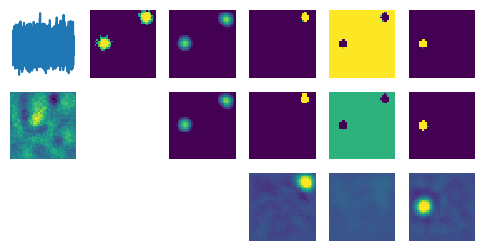

tensor(1.0000e-08) tensor(0.3299) >>><<
tensor(1.0000e-08) tensor(0.3299) >>><<
tensor(1.0000e-08) tensor(0.3299) >>><<


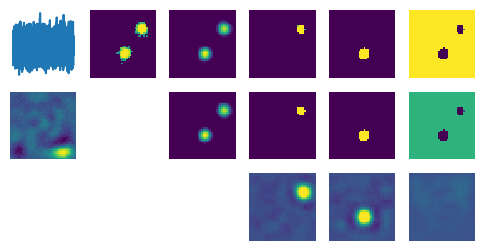

loss 4000 tensor(1.7018, grad_fn=<MseLossBackward0>) 0.00023999999999999998
tensor(1.0000e-08) tensor(0.2687) >>><<
tensor(1.0000e-08) tensor(0.2687) >>><<
tensor(1.0000e-08) tensor(0.2687) >>><<


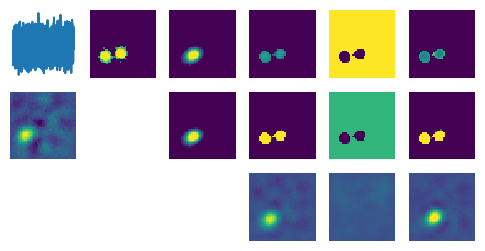

tensor(1.0000e-08) tensor(0.2040) >>><<
tensor(1.0000e-08) tensor(0.2040) >>><<
tensor(1.0000e-08) tensor(0.2040) >>><<


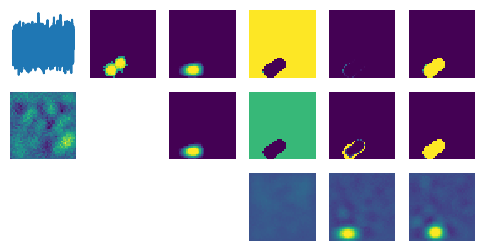

loss 4250 tensor(1.4731, grad_fn=<MseLossBackward0>) 0.00025499999999999996
tensor(1.0000e-08) tensor(0.1394) >>><<
tensor(1.0000e-08) tensor(0.1394) >>><<
tensor(1.0000e-08) tensor(0.1394) >>><<


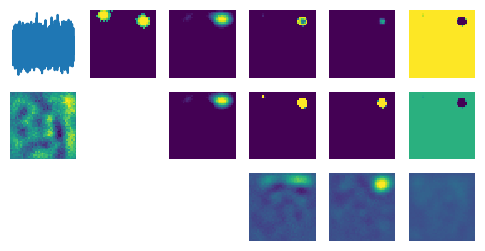

tensor(1.0000e-08) tensor(0.0980) >>><<
tensor(1.0000e-08) tensor(0.0980) >>><<
tensor(1.0000e-08) tensor(0.0980) >>><<


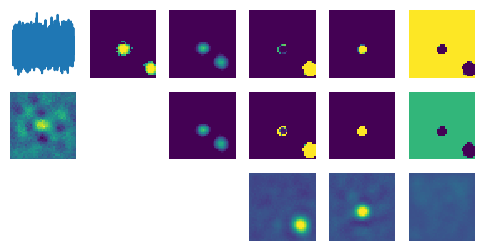

loss 4500 tensor(0.9556, grad_fn=<MseLossBackward0>) 0.00027
tensor(1.0000e-08) tensor(0.3250) >>><<
tensor(1.0000e-08) tensor(0.3250) >>><<
tensor(1.0000e-08) tensor(0.3250) >>><<


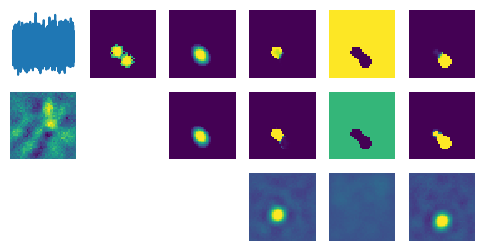

tensor(1.0000e-08) tensor(0.2971) >>><<
tensor(1.0000e-08) tensor(0.2971) >>><<
tensor(1.0000e-08) tensor(0.2971) >>><<


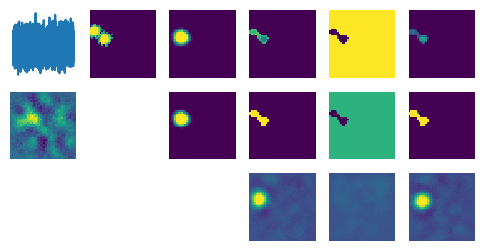

loss 4750 tensor(1.3471, grad_fn=<MseLossBackward0>) 0.000285
tensor(1.0000e-08) tensor(0.1615) >>><<
tensor(1.0000e-08) tensor(0.1615) >>><<
tensor(1.0000e-08) tensor(0.1615) >>><<


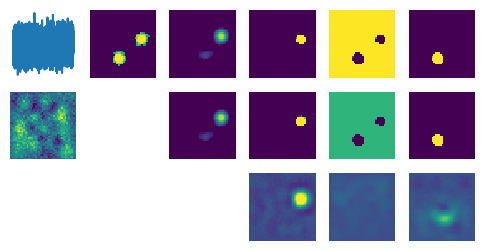

tensor(1.0000e-08) tensor(0.2341) >>><<
tensor(1.0000e-08) tensor(0.2341) >>><<
tensor(1.0000e-08) tensor(0.2341) >>><<


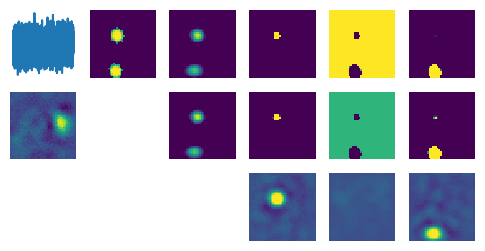

loss 5000 tensor(1.4567, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1557) >>><<
tensor(1.0000e-08) tensor(0.1557) >>><<
tensor(1.0000e-08) tensor(0.1557) >>><<


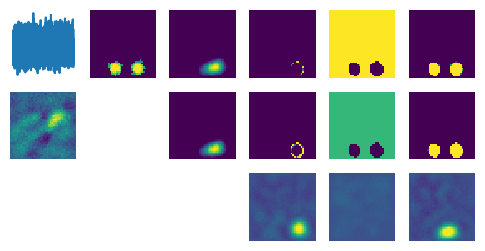

tensor(1.0000e-08) tensor(0.4682) >>><<
tensor(1.0000e-08) tensor(0.4682) >>><<
tensor(1.0000e-08) tensor(0.4682) >>><<


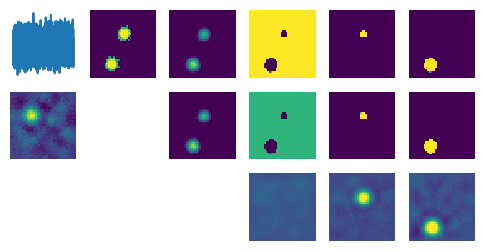

loss 5250 tensor(1.3717, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3137) >>><<
tensor(1.0000e-08) tensor(0.3137) >>><<
tensor(1.0000e-08) tensor(0.3137) >>><<


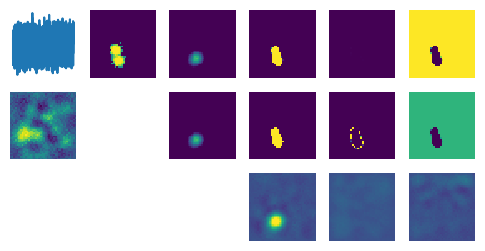

tensor(1.0000e-08) tensor(0.5649) >>><<
tensor(1.0000e-08) tensor(0.5649) >>><<
tensor(1.0000e-08) tensor(0.5649) >>><<


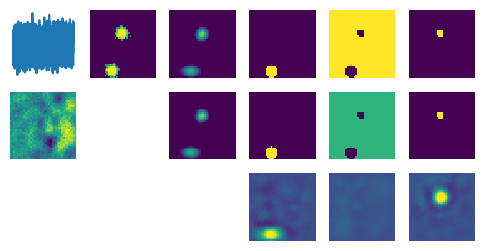

loss 5500 tensor(0.9740, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1396) >>><<
tensor(1.0000e-08) tensor(0.1396) >>><<
tensor(1.0000e-08) tensor(0.1396) >>><<


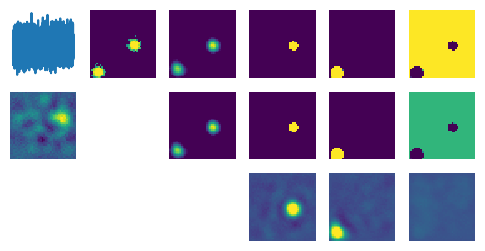

tensor(1.0000e-08) tensor(0.2307) >>><<
tensor(1.0000e-08) tensor(0.2307) >>><<
tensor(1.0000e-08) tensor(0.2307) >>><<


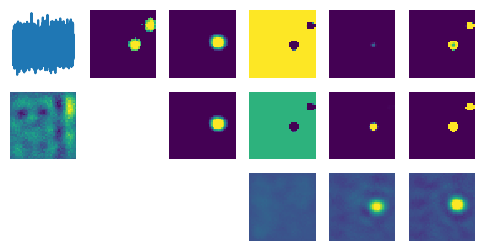

loss 5750 tensor(1.1613, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1318) >>><<
tensor(1.0000e-08) tensor(0.1318) >>><<
tensor(1.0000e-08) tensor(0.1318) >>><<


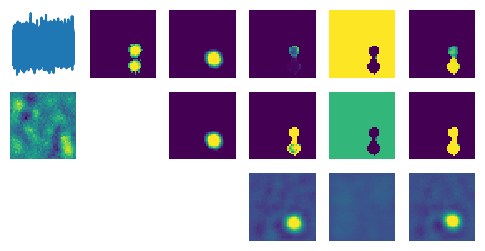

tensor(1.0000e-08) tensor(0.1231) >>><<
tensor(1.0000e-08) tensor(0.1231) >>><<
tensor(1.0000e-08) tensor(0.1231) >>><<


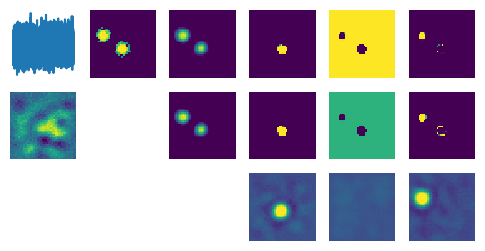

loss 6000 tensor(0.8997, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0708) >>><<
tensor(1.0000e-08) tensor(0.0708) >>><<
tensor(1.0000e-08) tensor(0.0708) >>><<


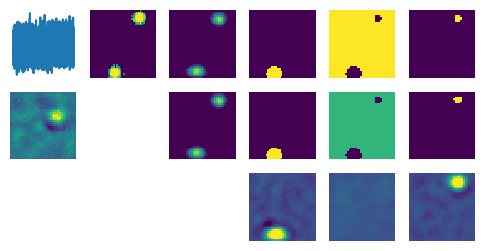

tensor(1.0000e-08) tensor(0.0662) >>><<
tensor(1.0000e-08) tensor(0.0662) >>><<
tensor(1.0000e-08) tensor(0.0662) >>><<


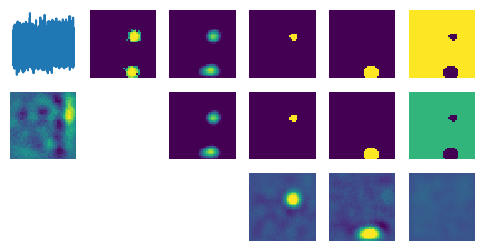

loss 6250 tensor(0.8814, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1371) >>><<
tensor(1.0000e-08) tensor(0.1371) >>><<
tensor(1.0000e-08) tensor(0.1371) >>><<


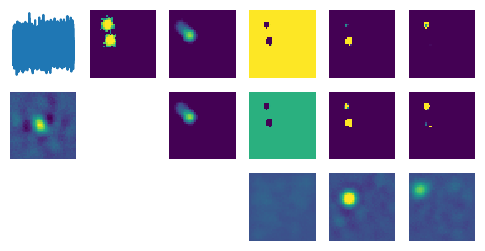

tensor(1.0000e-08) tensor(0.1055) >>><<
tensor(1.0000e-08) tensor(0.1055) >>><<
tensor(1.0000e-08) tensor(0.1055) >>><<


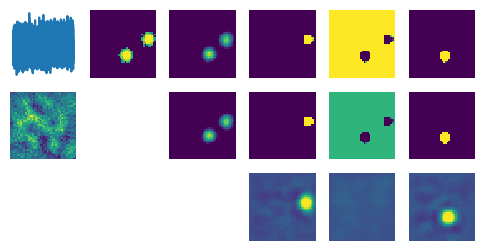

loss 6500 tensor(0.9277, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0834) >>><<
tensor(1.0000e-08) tensor(0.0834) >>><<
tensor(1.0000e-08) tensor(0.0834) >>><<


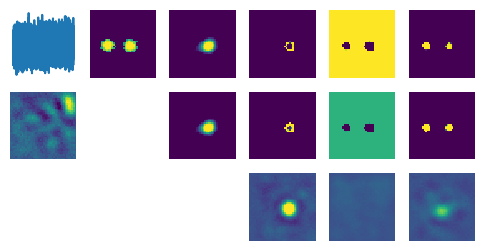

tensor(1.0000e-08) tensor(0.0988) >>><<
tensor(1.0000e-08) tensor(0.0988) >>><<
tensor(1.0000e-08) tensor(0.0988) >>><<


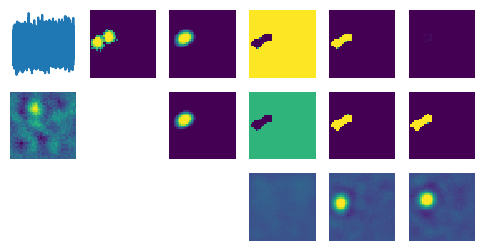

loss 6750 tensor(1.1103, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2375) >>><<
tensor(1.0000e-08) tensor(0.2375) >>><<
tensor(1.0000e-08) tensor(0.2375) >>><<


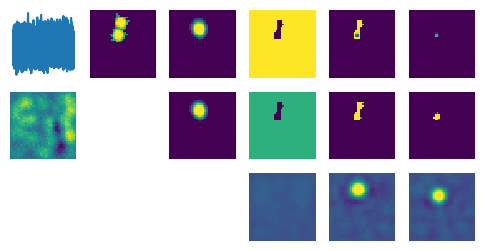

tensor(1.0000e-08) tensor(0.2471) >>><<
tensor(1.0000e-08) tensor(0.2471) >>><<
tensor(1.0000e-08) tensor(0.2471) >>><<


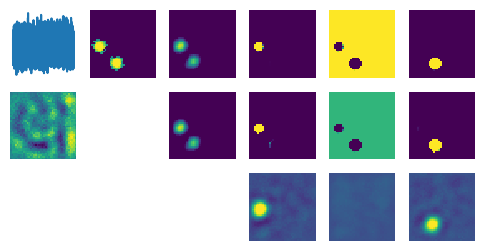

loss 7000 tensor(1.1339, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0919) >>><<
tensor(1.0000e-08) tensor(0.0919) >>><<
tensor(1.0000e-08) tensor(0.0919) >>><<


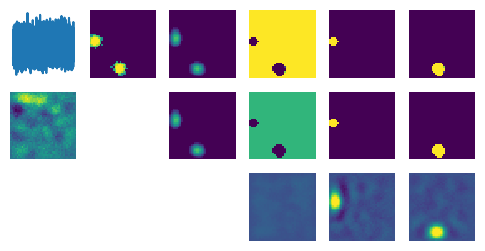

tensor(1.0000e-08) tensor(0.0803) >>><<
tensor(1.0000e-08) tensor(0.0803) >>><<
tensor(1.0000e-08) tensor(0.0803) >>><<


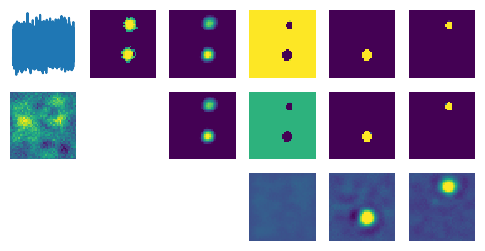

loss 7250 tensor(0.9350, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1175) >>><<
tensor(1.0000e-08) tensor(0.1175) >>><<
tensor(1.0000e-08) tensor(0.1175) >>><<


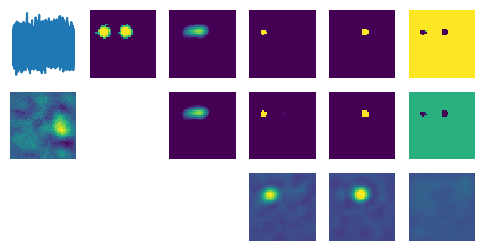

tensor(1.0000e-08) tensor(0.1697) >>><<
tensor(1.0000e-08) tensor(0.1697) >>><<
tensor(1.0000e-08) tensor(0.1697) >>><<


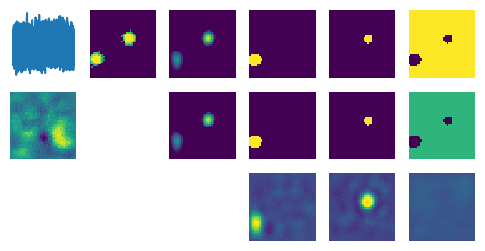

loss 7500 tensor(1.4216, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1114) >>><<
tensor(1.0000e-08) tensor(0.1114) >>><<
tensor(1.0000e-08) tensor(0.1114) >>><<


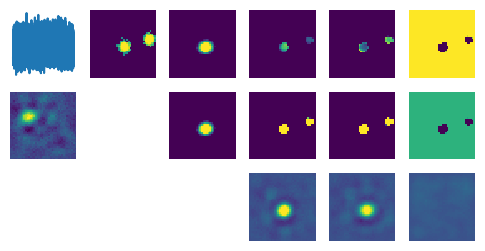

tensor(1.0000e-08) tensor(0.1037) >>><<
tensor(1.0000e-08) tensor(0.1037) >>><<
tensor(1.0000e-08) tensor(0.1037) >>><<


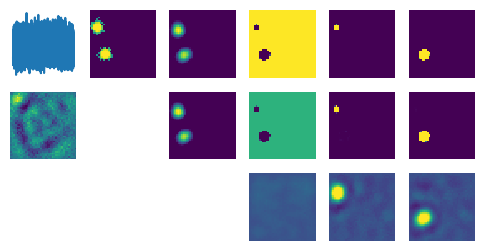

loss 7750 tensor(1.0679, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3321) >>><<
tensor(1.0000e-08) tensor(0.3321) >>><<
tensor(1.0000e-08) tensor(0.3321) >>><<


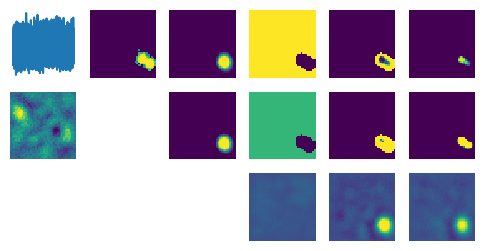

tensor(1.0000e-08) tensor(0.1990) >>><<
tensor(1.0000e-08) tensor(0.1990) >>><<
tensor(1.0000e-08) tensor(0.1990) >>><<


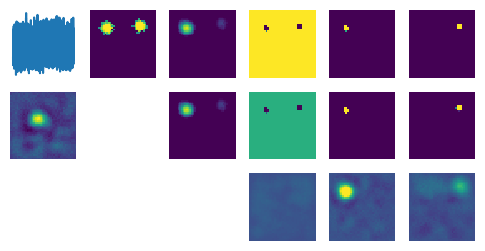

loss 8000 tensor(1.4065, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2292) >>><<
tensor(1.0000e-08) tensor(0.2292) >>><<
tensor(1.0000e-08) tensor(0.2292) >>><<


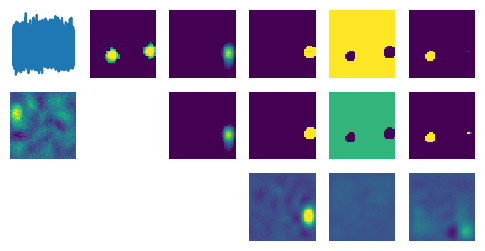

tensor(1.0000e-08) tensor(0.4503) >>><<
tensor(1.0000e-08) tensor(0.4503) >>><<
tensor(1.0000e-08) tensor(0.4503) >>><<


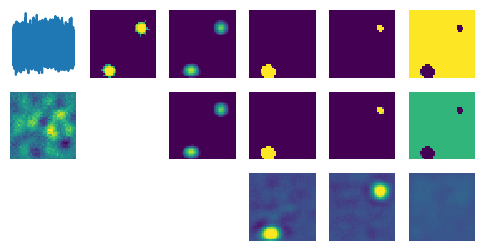

loss 8250 tensor(1.6927, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.9714) >>><<
tensor(1.0000e-08) tensor(0.9714) >>><<
tensor(1.0000e-08) tensor(0.9714) >>><<


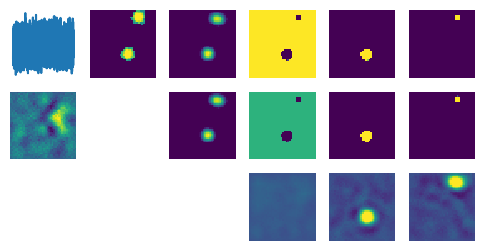

tensor(1.0000e-08) tensor(0.1108) >>><<
tensor(1.0000e-08) tensor(0.1108) >>><<
tensor(1.0000e-08) tensor(0.1108) >>><<


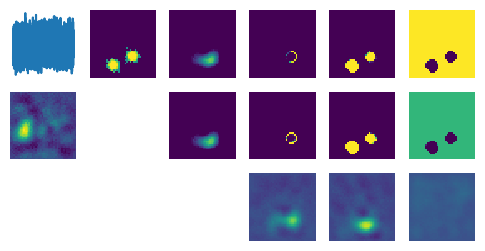

loss 8500 tensor(1.0118, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.7248) >>><<
tensor(1.0000e-08) tensor(0.7248) >>><<
tensor(1.0000e-08) tensor(0.7248) >>><<


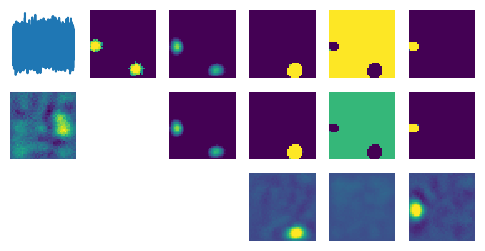

tensor(1.0000e-08) tensor(0.3951) >>><<
tensor(1.0000e-08) tensor(0.3951) >>><<
tensor(1.0000e-08) tensor(0.3951) >>><<


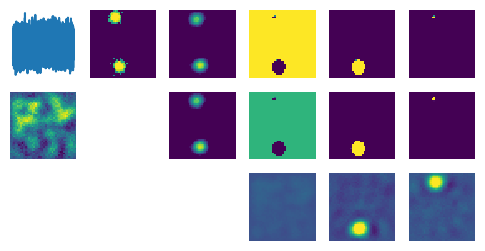

loss 8750 tensor(1.3737, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1593) >>><<
tensor(1.0000e-08) tensor(0.1593) >>><<
tensor(1.0000e-08) tensor(0.1593) >>><<


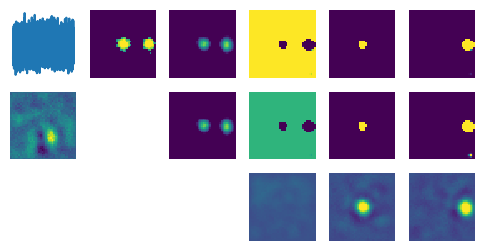

tensor(1.0000e-08) tensor(0.5975) >>><<
tensor(1.0000e-08) tensor(0.5975) >>><<
tensor(1.0000e-08) tensor(0.5975) >>><<


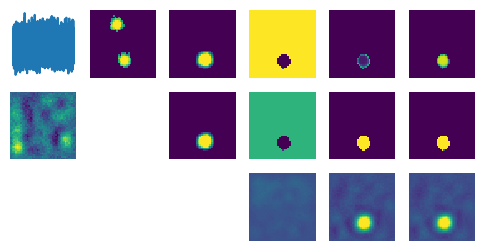

loss 9000 tensor(1.3557, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.8848) >>><<
tensor(1.0000e-08) tensor(0.8848) >>><<
tensor(1.0000e-08) tensor(0.8848) >>><<


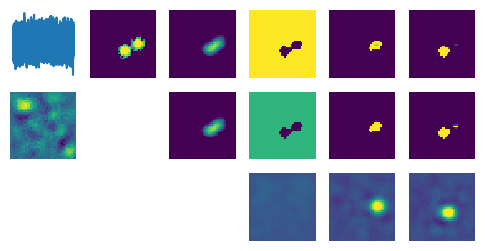

tensor(1.0000e-08) tensor(0.0960) >>><<
tensor(1.0000e-08) tensor(0.0960) >>><<
tensor(1.0000e-08) tensor(0.0960) >>><<


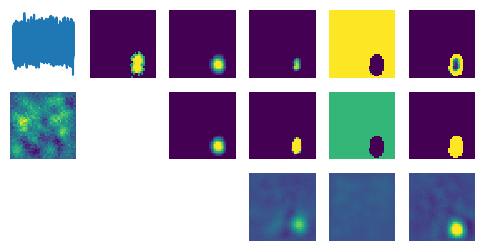

loss 9250 tensor(0.9107, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2546) >>><<
tensor(1.0000e-08) tensor(0.2546) >>><<
tensor(1.0000e-08) tensor(0.2546) >>><<


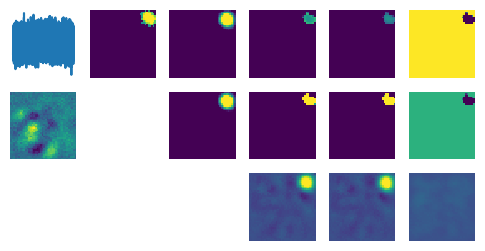

tensor(1.0000e-08) tensor(0.1727) >>><<
tensor(1.0000e-08) tensor(0.1727) >>><<
tensor(1.0000e-08) tensor(0.1727) >>><<


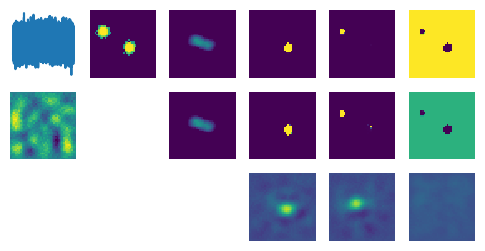

loss 9500 tensor(0.8228, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1037) >>><<
tensor(1.0000e-08) tensor(0.1037) >>><<
tensor(1.0000e-08) tensor(0.1037) >>><<


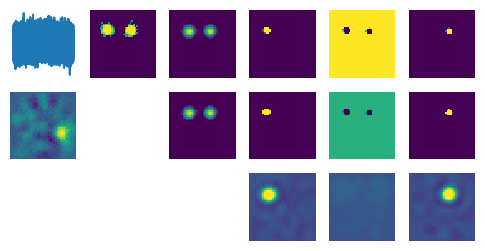

tensor(1.0000e-08) tensor(0.2878) >>><<
tensor(1.0000e-08) tensor(0.2878) >>><<
tensor(1.0000e-08) tensor(0.2878) >>><<


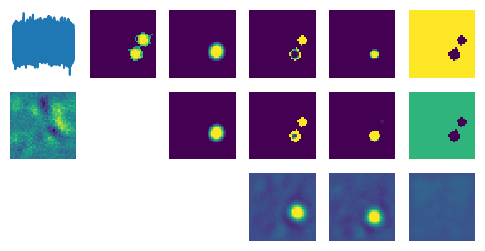

loss 9750 tensor(1.5988, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0589) >>><<
tensor(1.0000e-08) tensor(0.0589) >>><<
tensor(1.0000e-08) tensor(0.0589) >>><<


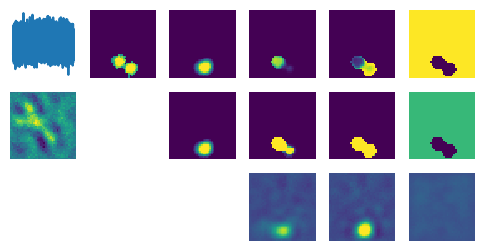

tensor(1.0000e-08) tensor(0.2701) >>><<
tensor(1.0000e-08) tensor(0.2701) >>><<
tensor(1.0000e-08) tensor(0.2701) >>><<


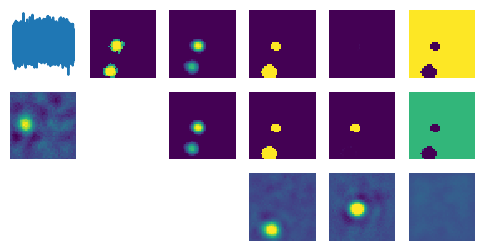

loss 10000 tensor(1.3800, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3777) >>><<
tensor(1.0000e-08) tensor(0.3777) >>><<
tensor(1.0000e-08) tensor(0.3777) >>><<


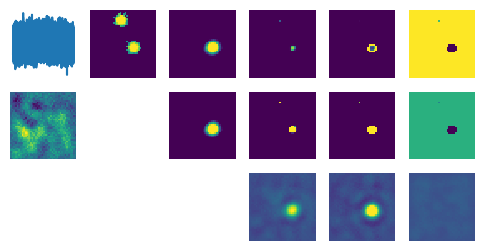

tensor(1.0000e-08) tensor(0.3826) >>><<
tensor(1.0000e-08) tensor(0.3826) >>><<
tensor(1.0000e-08) tensor(0.3826) >>><<


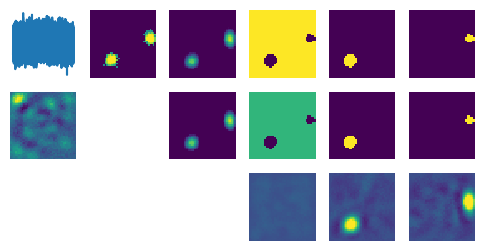

loss 10250 tensor(1.7691, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1497) >>><<
tensor(1.0000e-08) tensor(0.1497) >>><<
tensor(1.0000e-08) tensor(0.1497) >>><<


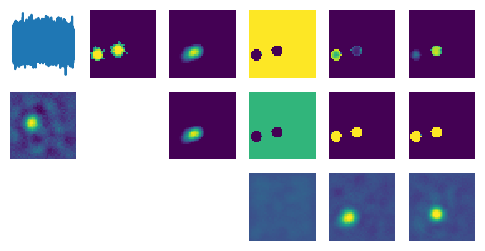

tensor(1.0000e-08) tensor(0.1848) >>><<
tensor(1.0000e-08) tensor(0.1848) >>><<
tensor(1.0000e-08) tensor(0.1848) >>><<


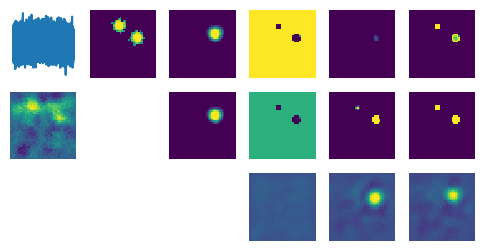

loss 10500 tensor(1.3563, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3323) >>><<
tensor(1.0000e-08) tensor(0.3323) >>><<
tensor(1.0000e-08) tensor(0.3323) >>><<


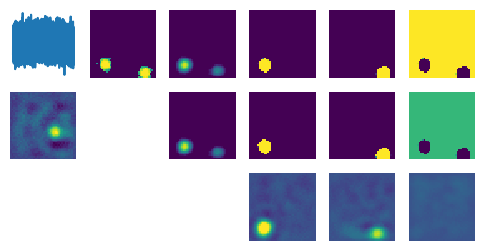

tensor(1.0000e-08) tensor(0.2273) >>><<
tensor(1.0000e-08) tensor(0.2273) >>><<
tensor(1.0000e-08) tensor(0.2273) >>><<


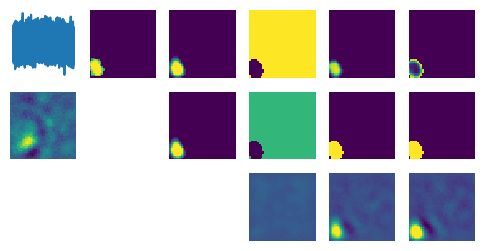

loss 10750 tensor(1.3141, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1833) >>><<
tensor(1.0000e-08) tensor(0.1833) >>><<
tensor(1.0000e-08) tensor(0.1833) >>><<


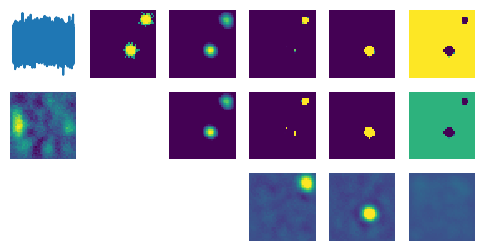

tensor(1.0000e-08) tensor(0.1838) >>><<
tensor(1.0000e-08) tensor(0.1838) >>><<
tensor(1.0000e-08) tensor(0.1838) >>><<


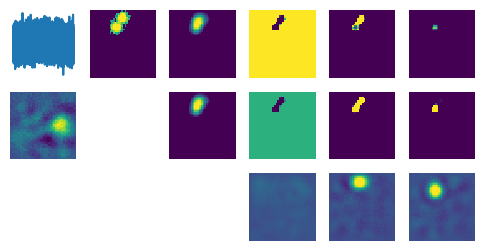

loss 11000 tensor(1.2626, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5656) >>><<
tensor(1.0000e-08) tensor(0.5656) >>><<
tensor(1.0000e-08) tensor(0.5656) >>><<


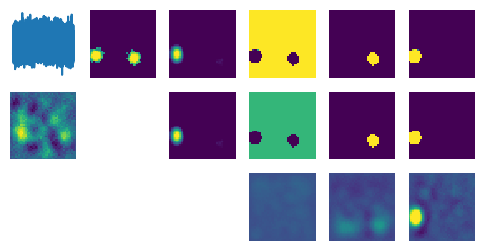

tensor(1.0000e-08) tensor(0.2645) >>><<
tensor(1.0000e-08) tensor(0.2645) >>><<
tensor(1.0000e-08) tensor(0.2645) >>><<


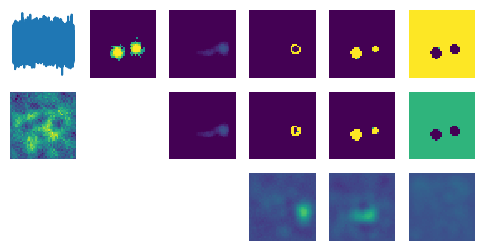

loss 11250 tensor(0.9561, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1892) >>><<
tensor(1.0000e-08) tensor(0.1892) >>><<
tensor(1.0000e-08) tensor(0.1892) >>><<


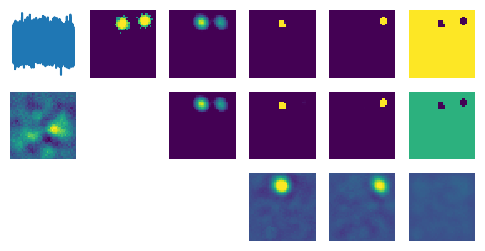

tensor(1.0000e-08) tensor(0.0758) >>><<
tensor(1.0000e-08) tensor(0.0758) >>><<
tensor(1.0000e-08) tensor(0.0758) >>><<


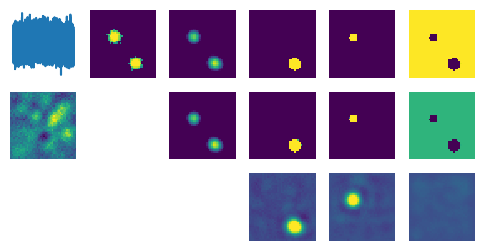

loss 11500 tensor(1.1985, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3477) >>><<
tensor(1.0000e-08) tensor(0.3477) >>><<
tensor(1.0000e-08) tensor(0.3477) >>><<


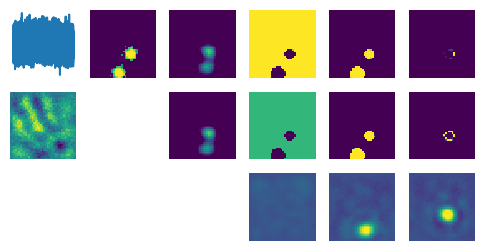

tensor(1.0000e-08) tensor(0.1310) >>><<
tensor(1.0000e-08) tensor(0.1310) >>><<
tensor(1.0000e-08) tensor(0.1310) >>><<


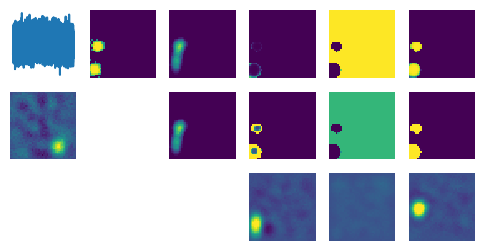

loss 11750 tensor(1.0151, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4018) >>><<
tensor(1.0000e-08) tensor(0.4018) >>><<
tensor(1.0000e-08) tensor(0.4018) >>><<


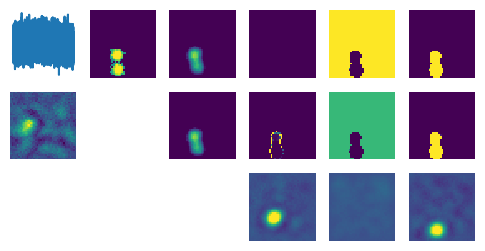

tensor(1.0000e-08) tensor(0.6136) >>><<
tensor(1.0000e-08) tensor(0.6136) >>><<
tensor(1.0000e-08) tensor(0.6136) >>><<


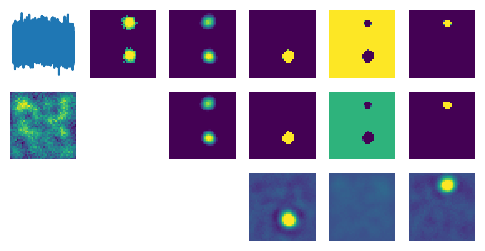

loss 12000 tensor(1.6694, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1195) >>><<
tensor(1.0000e-08) tensor(0.1195) >>><<
tensor(1.0000e-08) tensor(0.1195) >>><<


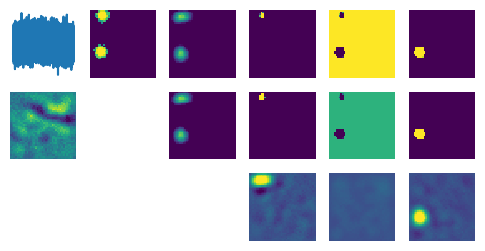

tensor(1.0000e-08) tensor(0.0926) >>><<
tensor(1.0000e-08) tensor(0.0926) >>><<
tensor(1.0000e-08) tensor(0.0926) >>><<


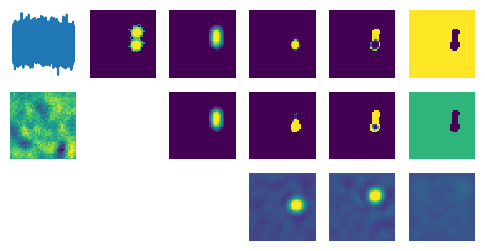

loss 12250 tensor(1.3396, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2454) >>><<
tensor(1.0000e-08) tensor(0.2454) >>><<
tensor(1.0000e-08) tensor(0.2454) >>><<


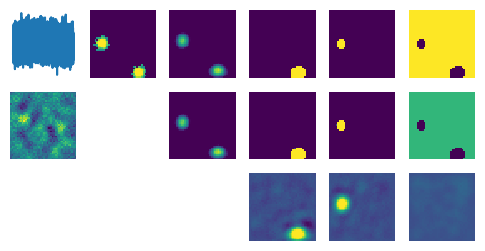

tensor(1.0000e-08) tensor(0.0844) >>><<
tensor(1.0000e-08) tensor(0.0844) >>><<
tensor(1.0000e-08) tensor(0.0844) >>><<


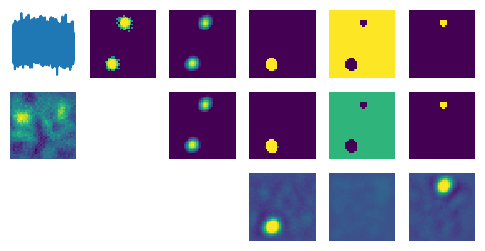

loss 12500 tensor(0.7349, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1757) >>><<
tensor(1.0000e-08) tensor(0.1757) >>><<
tensor(1.0000e-08) tensor(0.1757) >>><<


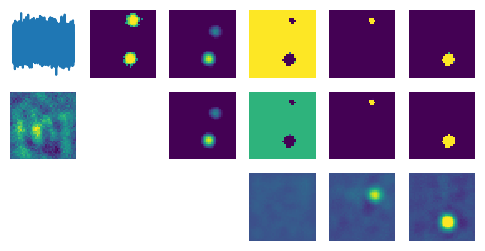

tensor(1.0000e-08) tensor(0.1959) >>><<
tensor(1.0000e-08) tensor(0.1959) >>><<
tensor(1.0000e-08) tensor(0.1959) >>><<


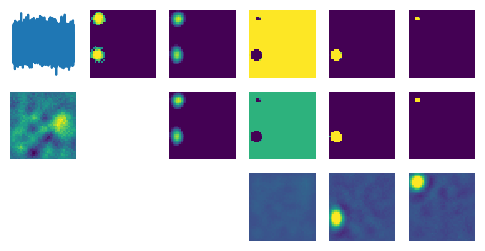

loss 12750 tensor(1.0961, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3186) >>><<
tensor(1.0000e-08) tensor(0.3186) >>><<
tensor(1.0000e-08) tensor(0.3186) >>><<


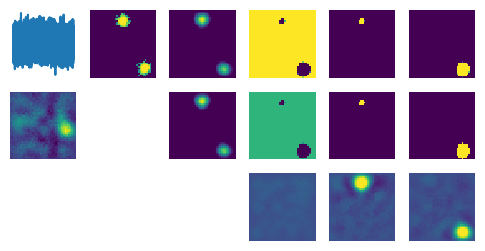

tensor(1.0000e-08) tensor(0.1131) >>><<
tensor(1.0000e-08) tensor(0.1131) >>><<
tensor(1.0000e-08) tensor(0.1131) >>><<


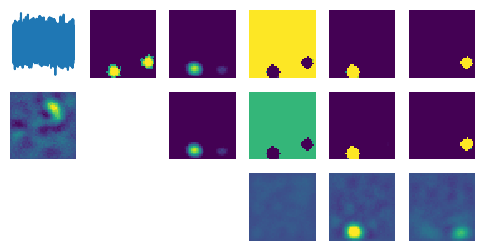

loss 13000 tensor(1.4949, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1565) >>><<
tensor(1.0000e-08) tensor(0.1565) >>><<
tensor(1.0000e-08) tensor(0.1565) >>><<


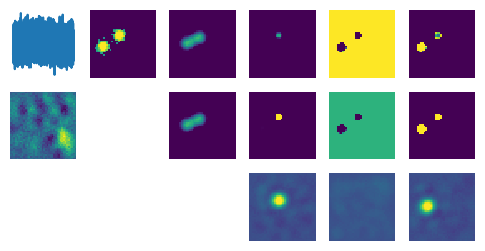

tensor(1.0000e-08) tensor(0.0898) >>><<
tensor(1.0000e-08) tensor(0.0898) >>><<
tensor(1.0000e-08) tensor(0.0898) >>><<


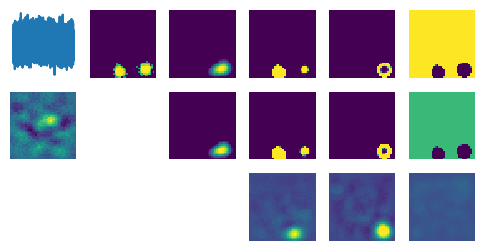

loss 13250 tensor(1.3020, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1197) >>><<
tensor(1.0000e-08) tensor(0.1197) >>><<
tensor(1.0000e-08) tensor(0.1197) >>><<


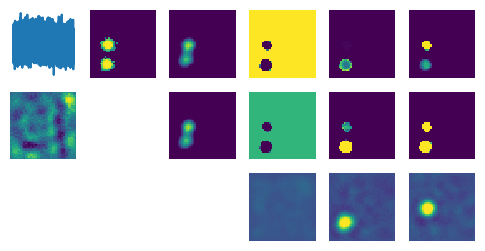

tensor(1.0000e-08) tensor(0.0894) >>><<
tensor(1.0000e-08) tensor(0.0894) >>><<
tensor(1.0000e-08) tensor(0.0894) >>><<


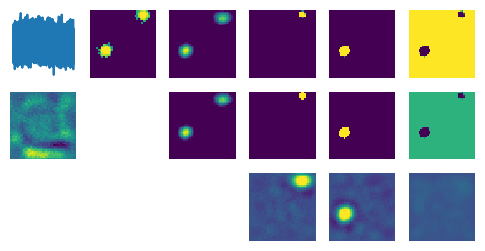

loss 13500 tensor(1.9648, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1019) >>><<
tensor(1.0000e-08) tensor(0.1019) >>><<
tensor(1.0000e-08) tensor(0.1019) >>><<


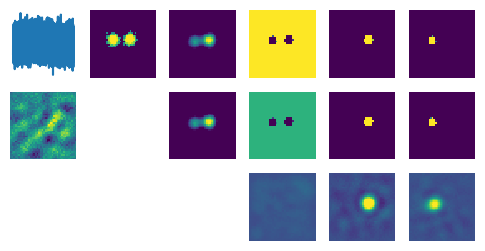

tensor(1.0000e-08) tensor(0.0843) >>><<
tensor(1.0000e-08) tensor(0.0843) >>><<
tensor(1.0000e-08) tensor(0.0843) >>><<


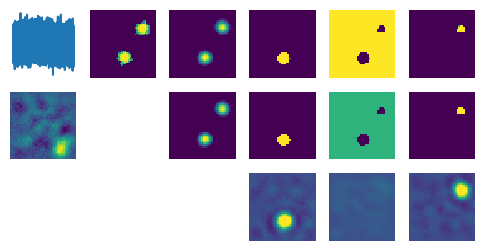

loss 13750 tensor(1.2432, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2866) >>><<
tensor(1.0000e-08) tensor(0.2866) >>><<
tensor(1.0000e-08) tensor(0.2866) >>><<


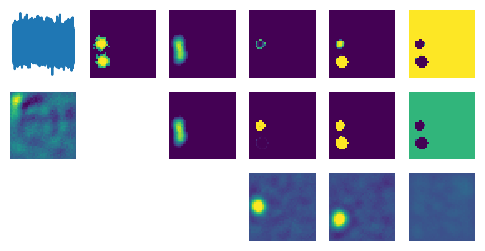

tensor(1.0000e-08) tensor(0.2756) >>><<
tensor(1.0000e-08) tensor(0.2756) >>><<
tensor(1.0000e-08) tensor(0.2756) >>><<


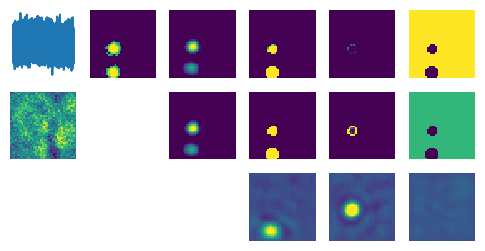

loss 14000 tensor(0.8176, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0716) >>><<
tensor(1.0000e-08) tensor(0.0716) >>><<
tensor(1.0000e-08) tensor(0.0716) >>><<


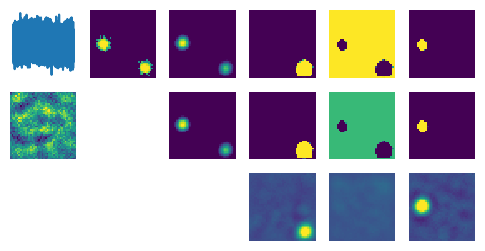

tensor(1.0000e-08) tensor(0.0458) >>><<
tensor(1.0000e-08) tensor(0.0458) >>><<
tensor(1.0000e-08) tensor(0.0458) >>><<


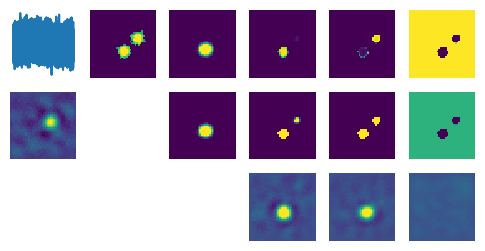

loss 14250 tensor(1.4685, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1985) >>><<
tensor(1.0000e-08) tensor(0.1985) >>><<
tensor(1.0000e-08) tensor(0.1985) >>><<


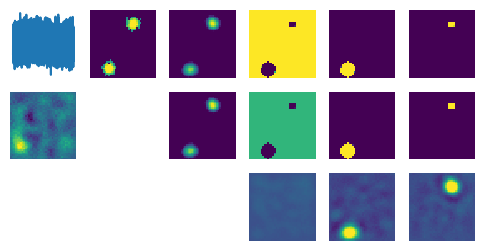

tensor(1.0000e-08) tensor(0.2892) >>><<
tensor(1.0000e-08) tensor(0.2892) >>><<
tensor(1.0000e-08) tensor(0.2892) >>><<


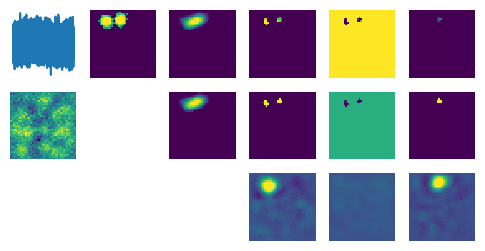

loss 14500 tensor(0.7612, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1251) >>><<
tensor(1.0000e-08) tensor(0.1251) >>><<
tensor(1.0000e-08) tensor(0.1251) >>><<


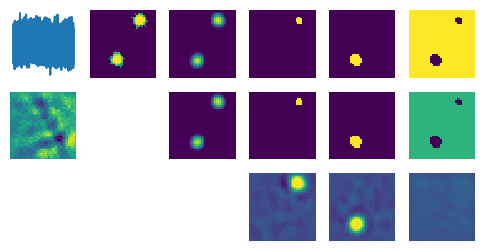

tensor(1.0000e-08) tensor(0.1250) >>><<
tensor(1.0000e-08) tensor(0.1250) >>><<
tensor(1.0000e-08) tensor(0.1250) >>><<


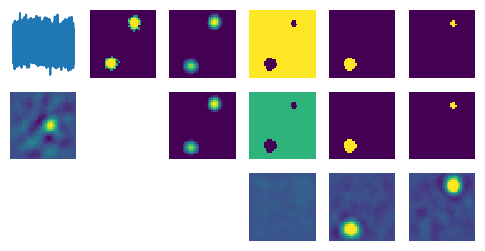

loss 14750 tensor(0.8095, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1561) >>><<
tensor(1.0000e-08) tensor(0.1561) >>><<
tensor(1.0000e-08) tensor(0.1561) >>><<


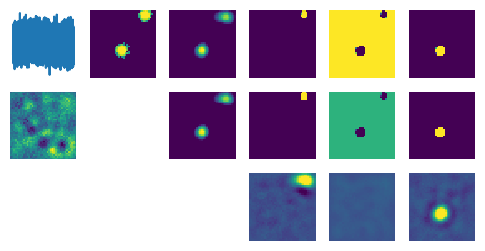

tensor(1.0000e-08) tensor(0.9639) >>><<
tensor(1.0000e-08) tensor(0.9639) >>><<
tensor(1.0000e-08) tensor(0.9639) >>><<


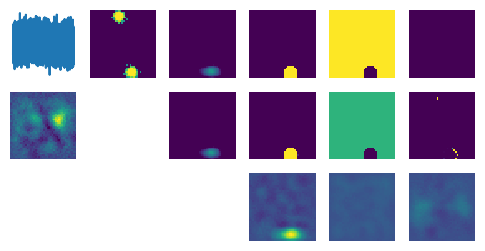

loss 15000 tensor(1.4283, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2412) >>><<
tensor(1.0000e-08) tensor(0.2412) >>><<
tensor(1.0000e-08) tensor(0.2412) >>><<


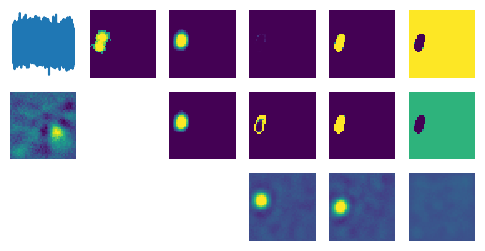

tensor(1.0000e-08) tensor(0.4157) >>><<
tensor(1.0000e-08) tensor(0.4157) >>><<
tensor(1.0000e-08) tensor(0.4157) >>><<


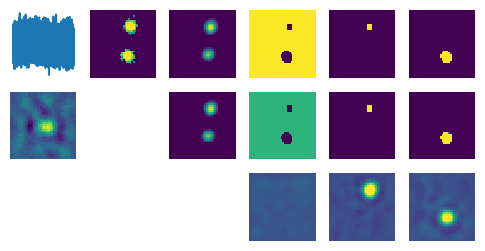

loss 15250 tensor(0.7873, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0993) >>><<
tensor(1.0000e-08) tensor(0.0993) >>><<
tensor(1.0000e-08) tensor(0.0993) >>><<


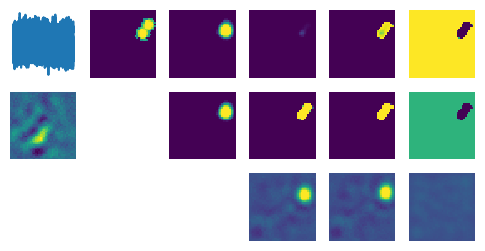

tensor(1.0000e-08) tensor(0.0842) >>><<
tensor(1.0000e-08) tensor(0.0842) >>><<
tensor(1.0000e-08) tensor(0.0842) >>><<


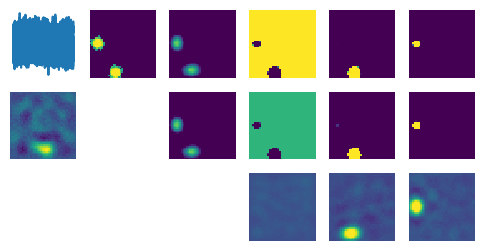

loss 15500 tensor(0.9841, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1677) >>><<
tensor(1.0000e-08) tensor(0.1677) >>><<
tensor(1.0000e-08) tensor(0.1677) >>><<


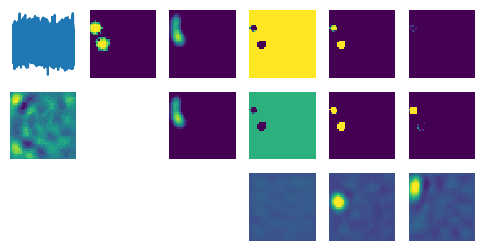

tensor(1.0000e-08) tensor(0.1214) >>><<
tensor(1.0000e-08) tensor(0.1214) >>><<
tensor(1.0000e-08) tensor(0.1214) >>><<


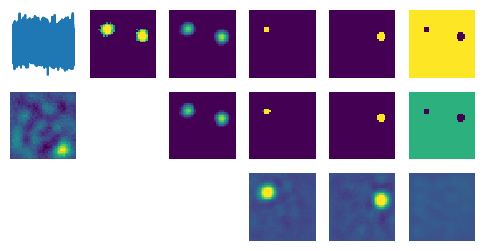

loss 15750 tensor(1.4146, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2441) >>><<
tensor(1.0000e-08) tensor(0.2441) >>><<
tensor(1.0000e-08) tensor(0.2441) >>><<


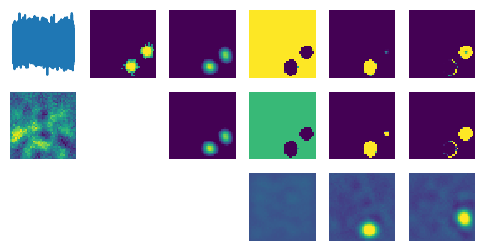

tensor(1.0000e-08) tensor(0.2064) >>><<
tensor(1.0000e-08) tensor(0.2064) >>><<
tensor(1.0000e-08) tensor(0.2064) >>><<


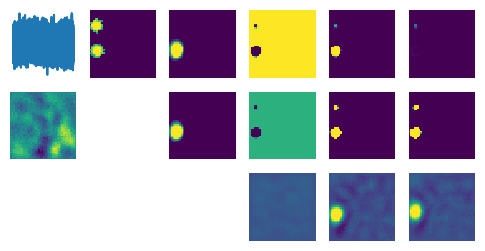

loss 16000 tensor(0.8652, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0965) >>><<
tensor(1.0000e-08) tensor(0.0965) >>><<
tensor(1.0000e-08) tensor(0.0965) >>><<


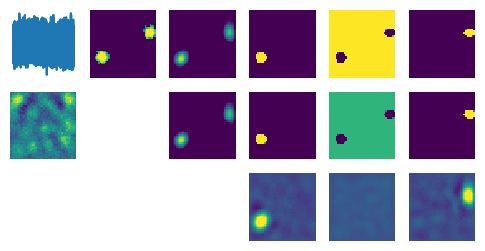

tensor(1.0000e-08) tensor(0.1000) >>><<
tensor(1.0000e-08) tensor(0.1000) >>><<
tensor(1.0000e-08) tensor(0.1000) >>><<


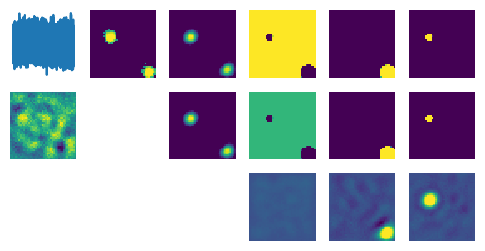

loss 16250 tensor(1.2345, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2073) >>><<
tensor(1.0000e-08) tensor(0.2073) >>><<
tensor(1.0000e-08) tensor(0.2073) >>><<


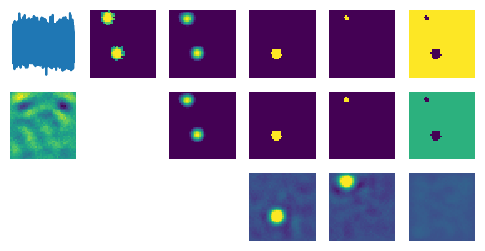

tensor(1.0000e-08) tensor(0.1959) >>><<
tensor(1.0000e-08) tensor(0.1959) >>><<
tensor(1.0000e-08) tensor(0.1959) >>><<


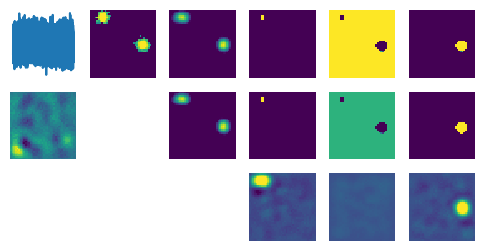

loss 16500 tensor(1.1837, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1550) >>><<
tensor(1.0000e-08) tensor(0.1550) >>><<
tensor(1.0000e-08) tensor(0.1550) >>><<


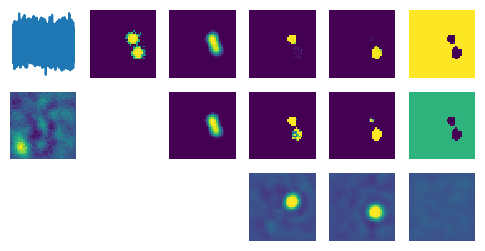

tensor(1.0000e-08) tensor(0.0849) >>><<
tensor(1.0000e-08) tensor(0.0849) >>><<
tensor(1.0000e-08) tensor(0.0849) >>><<


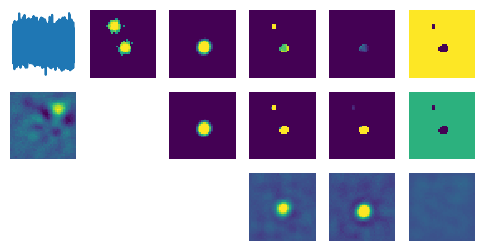

loss 16750 tensor(1.0214, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1490) >>><<
tensor(1.0000e-08) tensor(0.1490) >>><<
tensor(1.0000e-08) tensor(0.1490) >>><<


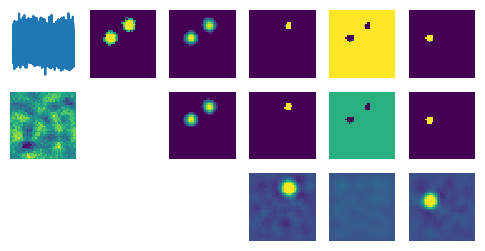

tensor(1.0000e-08) tensor(0.5032) >>><<
tensor(1.0000e-08) tensor(0.5032) >>><<
tensor(1.0000e-08) tensor(0.5032) >>><<


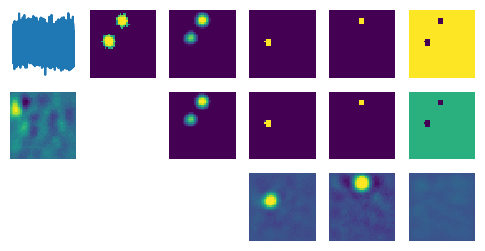

loss 17000 tensor(1.5741, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2423) >>><<
tensor(1.0000e-08) tensor(0.2423) >>><<
tensor(1.0000e-08) tensor(0.2423) >>><<


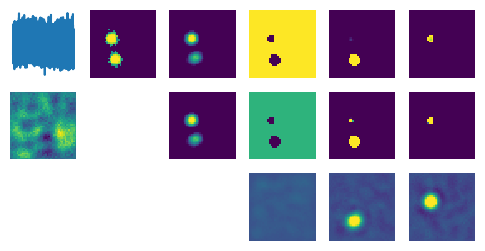

tensor(1.0000e-08) tensor(0.0896) >>><<
tensor(1.0000e-08) tensor(0.0896) >>><<
tensor(1.0000e-08) tensor(0.0896) >>><<


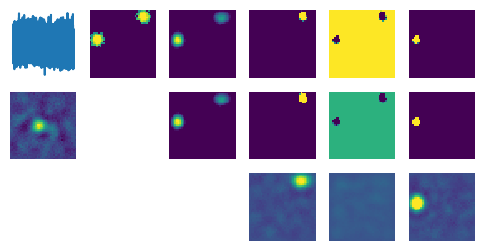

loss 17250 tensor(1.0745, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2553) >>><<
tensor(1.0000e-08) tensor(0.2553) >>><<
tensor(1.0000e-08) tensor(0.2553) >>><<


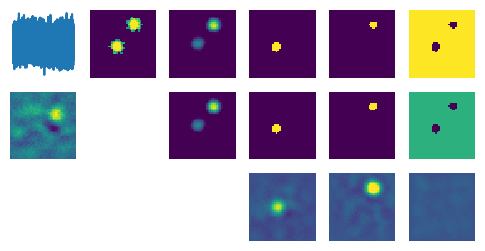

tensor(1.0000e-08) tensor(0.3722) >>><<
tensor(1.0000e-08) tensor(0.3722) >>><<
tensor(1.0000e-08) tensor(0.3722) >>><<


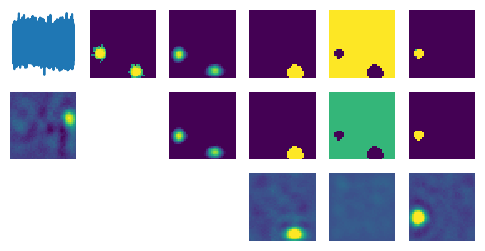

loss 17500 tensor(2.2974, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3711) >>><<
tensor(1.0000e-08) tensor(0.3711) >>><<
tensor(1.0000e-08) tensor(0.3711) >>><<


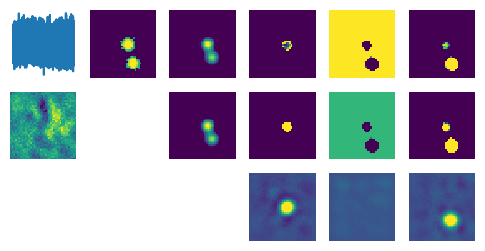

tensor(1.0000e-08) tensor(0.3664) >>><<
tensor(1.0000e-08) tensor(0.3664) >>><<
tensor(1.0000e-08) tensor(0.3664) >>><<


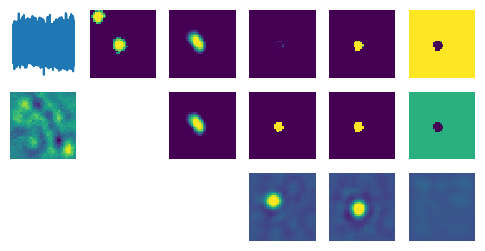

loss 17750 tensor(0.8513, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1117) >>><<
tensor(1.0000e-08) tensor(0.1117) >>><<
tensor(1.0000e-08) tensor(0.1117) >>><<


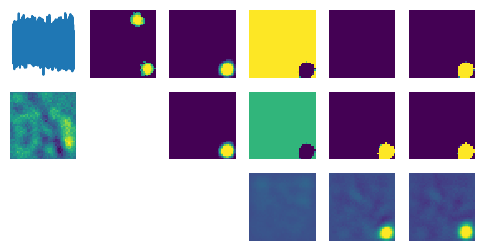

tensor(1.0000e-08) tensor(0.1269) >>><<
tensor(1.0000e-08) tensor(0.1269) >>><<
tensor(1.0000e-08) tensor(0.1269) >>><<


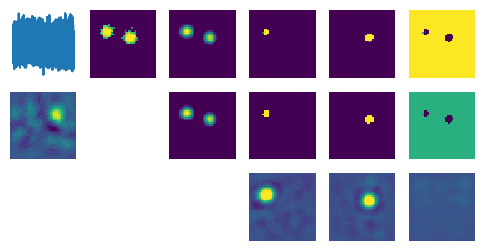

loss 18000 tensor(1.3460, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3118) >>><<
tensor(1.0000e-08) tensor(0.3118) >>><<
tensor(1.0000e-08) tensor(0.3118) >>><<


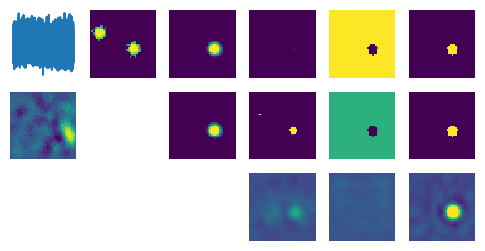

tensor(1.0000e-08) tensor(0.1986) >>><<
tensor(1.0000e-08) tensor(0.1986) >>><<
tensor(1.0000e-08) tensor(0.1986) >>><<


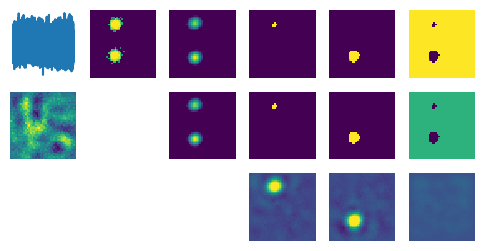

loss 18250 tensor(0.8270, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4304) >>><<
tensor(1.0000e-08) tensor(0.4304) >>><<
tensor(1.0000e-08) tensor(0.4304) >>><<


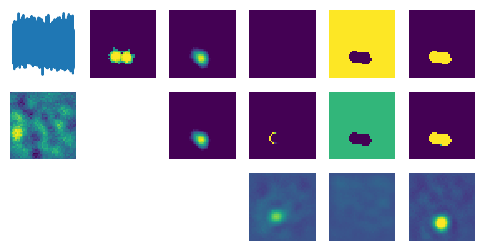

tensor(1.0000e-08) tensor(0.1628) >>><<
tensor(1.0000e-08) tensor(0.1628) >>><<
tensor(1.0000e-08) tensor(0.1628) >>><<


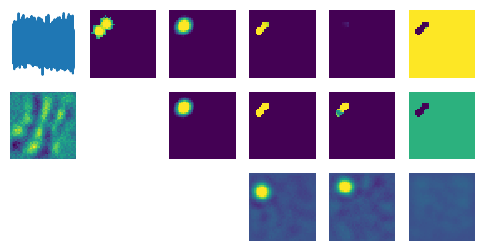

loss 18500 tensor(1.1052, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0513) >>><<
tensor(1.0000e-08) tensor(0.0513) >>><<
tensor(1.0000e-08) tensor(0.0513) >>><<


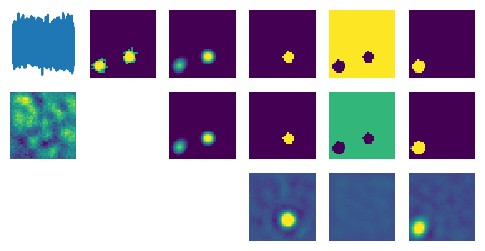

tensor(1.0000e-08) tensor(0.2732) >>><<
tensor(1.0000e-08) tensor(0.2732) >>><<
tensor(1.0000e-08) tensor(0.2732) >>><<


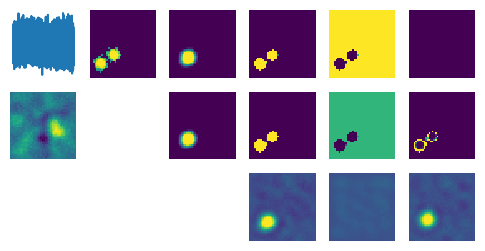

loss 18750 tensor(1.2694, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1787) >>><<
tensor(1.0000e-08) tensor(0.1787) >>><<
tensor(1.0000e-08) tensor(0.1787) >>><<


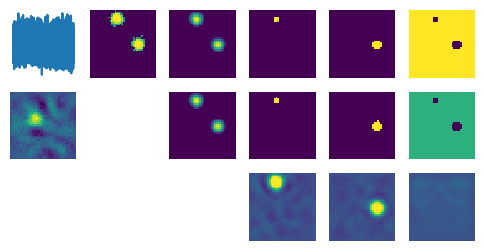

tensor(1.0000e-08) tensor(0.5118) >>><<
tensor(1.0000e-08) tensor(0.5118) >>><<
tensor(1.0000e-08) tensor(0.5118) >>><<


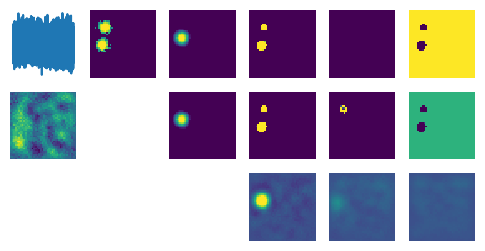

loss 19000 tensor(1.1284, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2858) >>><<
tensor(1.0000e-08) tensor(0.2858) >>><<
tensor(1.0000e-08) tensor(0.2858) >>><<


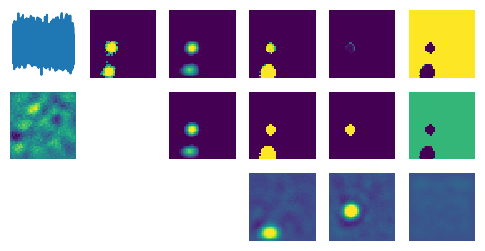

tensor(1.0000e-08) tensor(0.2076) >>><<
tensor(1.0000e-08) tensor(0.2076) >>><<
tensor(1.0000e-08) tensor(0.2076) >>><<


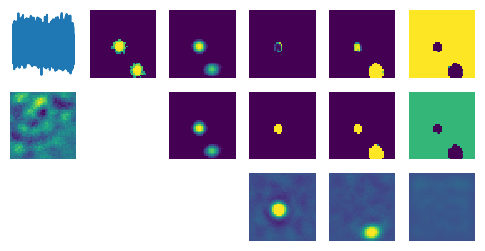

loss 19250 tensor(0.8174, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3344) >>><<
tensor(1.0000e-08) tensor(0.3344) >>><<
tensor(1.0000e-08) tensor(0.3344) >>><<


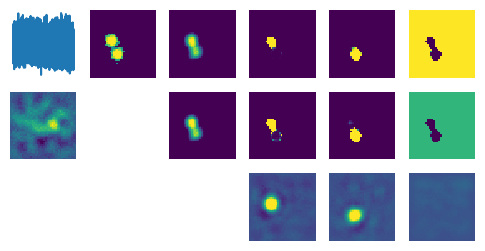

tensor(1.0000e-08) tensor(0.1786) >>><<
tensor(1.0000e-08) tensor(0.1786) >>><<
tensor(1.0000e-08) tensor(0.1786) >>><<


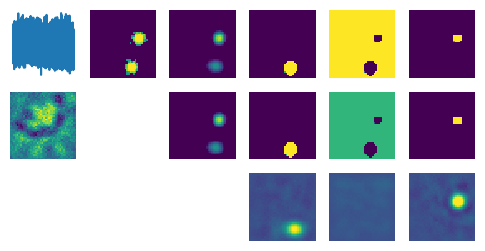

loss 19500 tensor(1.0299, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1238) >>><<
tensor(1.0000e-08) tensor(0.1238) >>><<
tensor(1.0000e-08) tensor(0.1238) >>><<


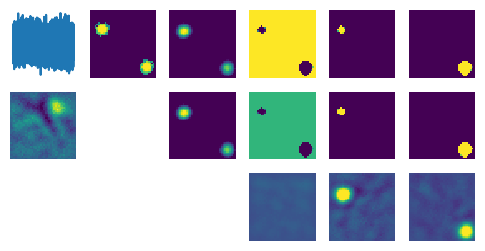

tensor(1.0000e-08) tensor(0.1164) >>><<
tensor(1.0000e-08) tensor(0.1164) >>><<
tensor(1.0000e-08) tensor(0.1164) >>><<


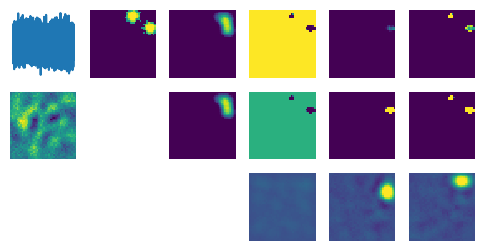

loss 19750 tensor(1.1480, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1879) >>><<
tensor(1.0000e-08) tensor(0.1879) >>><<
tensor(1.0000e-08) tensor(0.1879) >>><<


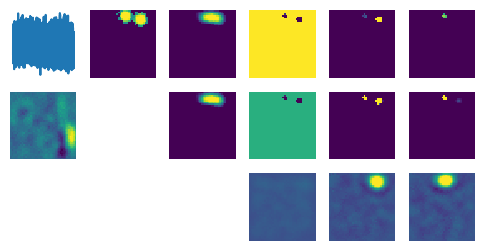

tensor(1.0000e-08) tensor(0.1851) >>><<
tensor(1.0000e-08) tensor(0.1851) >>><<
tensor(1.0000e-08) tensor(0.1851) >>><<


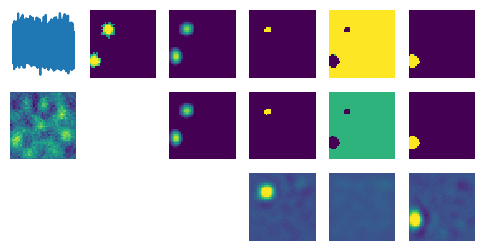

loss 20000 tensor(1.3721, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0929) >>><<
tensor(1.0000e-08) tensor(0.0929) >>><<
tensor(1.0000e-08) tensor(0.0929) >>><<


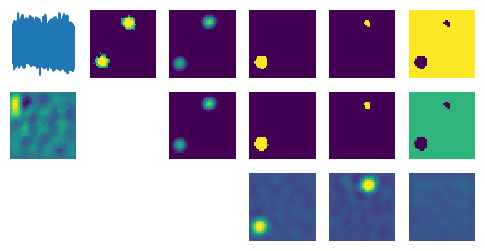

tensor(1.0000e-08) tensor(0.0919) >>><<
tensor(1.0000e-08) tensor(0.0919) >>><<
tensor(1.0000e-08) tensor(0.0919) >>><<


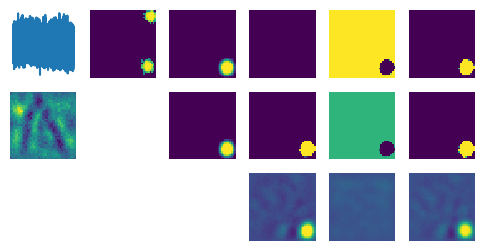

loss 20250 tensor(1.3745, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1016) >>><<
tensor(1.0000e-08) tensor(0.1016) >>><<
tensor(1.0000e-08) tensor(0.1016) >>><<


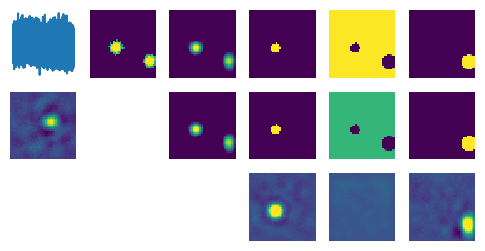

tensor(1.0000e-08) tensor(0.3405) >>><<
tensor(1.0000e-08) tensor(0.3405) >>><<
tensor(1.0000e-08) tensor(0.3405) >>><<


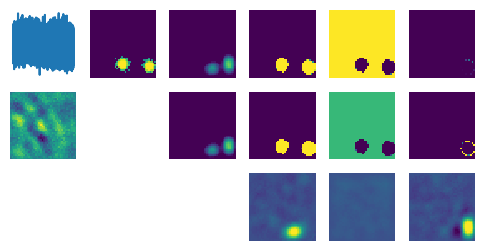

loss 20500 tensor(2.0235, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2515) >>><<
tensor(1.0000e-08) tensor(0.2515) >>><<
tensor(1.0000e-08) tensor(0.2515) >>><<


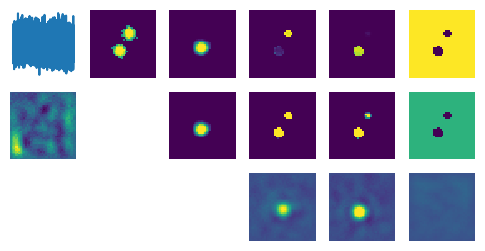

tensor(1.0000e-08) tensor(0.1838) >>><<
tensor(1.0000e-08) tensor(0.1838) >>><<
tensor(1.0000e-08) tensor(0.1838) >>><<


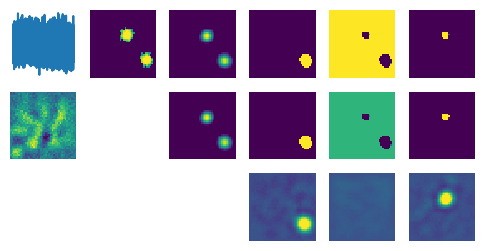

loss 20750 tensor(0.8894, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4675) >>><<
tensor(1.0000e-08) tensor(0.4675) >>><<
tensor(1.0000e-08) tensor(0.4675) >>><<


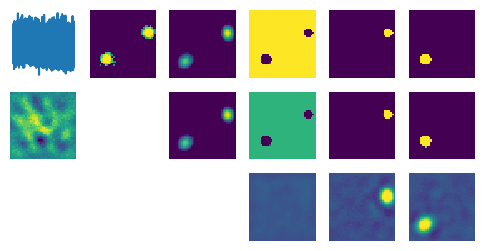

tensor(1.0000e-08) tensor(0.1312) >>><<
tensor(1.0000e-08) tensor(0.1312) >>><<
tensor(1.0000e-08) tensor(0.1312) >>><<


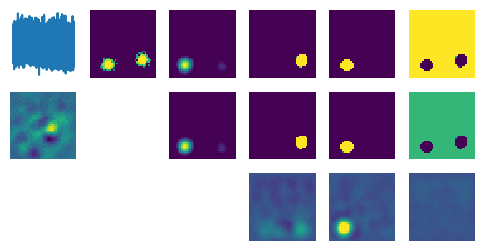

loss 21000 tensor(1.8254, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1243) >>><<
tensor(1.0000e-08) tensor(0.1243) >>><<
tensor(1.0000e-08) tensor(0.1243) >>><<


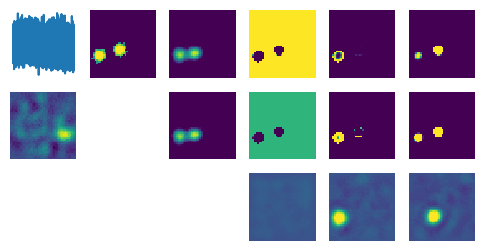

tensor(1.0000e-08) tensor(0.2097) >>><<
tensor(1.0000e-08) tensor(0.2097) >>><<
tensor(1.0000e-08) tensor(0.2097) >>><<


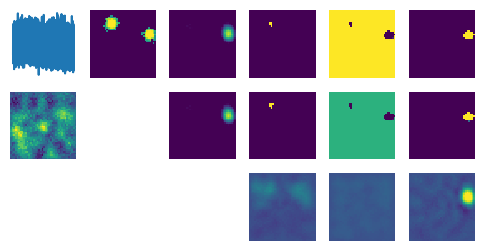

loss 21250 tensor(1.3913, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5917) >>><<
tensor(1.0000e-08) tensor(0.5917) >>><<
tensor(1.0000e-08) tensor(0.5917) >>><<


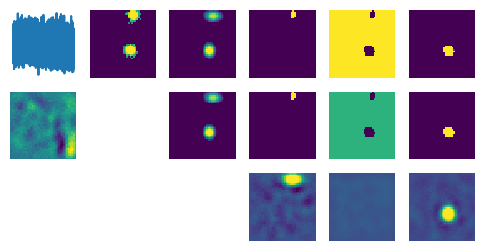

tensor(1.0000e-08) tensor(0.0796) >>><<
tensor(1.0000e-08) tensor(0.0796) >>><<
tensor(1.0000e-08) tensor(0.0796) >>><<


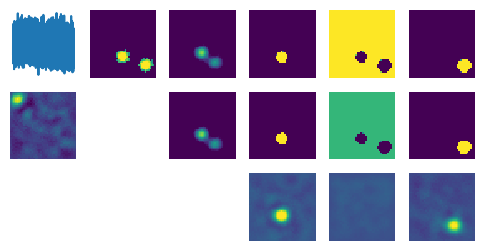

loss 21500 tensor(1.5735, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2359) >>><<
tensor(1.0000e-08) tensor(0.2359) >>><<
tensor(1.0000e-08) tensor(0.2359) >>><<


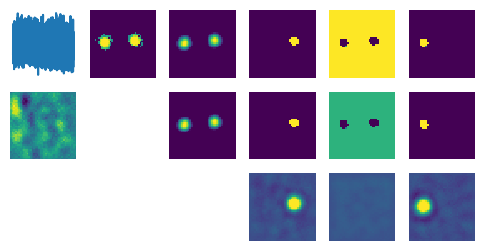

tensor(1.0000e-08) tensor(0.2124) >>><<
tensor(1.0000e-08) tensor(0.2124) >>><<
tensor(1.0000e-08) tensor(0.2124) >>><<


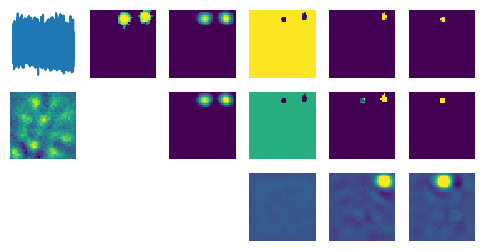

loss 21750 tensor(0.7290, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.6286) >>><<
tensor(1.0000e-08) tensor(0.6286) >>><<
tensor(1.0000e-08) tensor(0.6286) >>><<


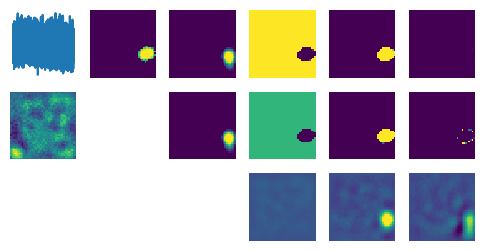

tensor(1.0000e-08) tensor(0.5038) >>><<
tensor(1.0000e-08) tensor(0.5038) >>><<
tensor(1.0000e-08) tensor(0.5038) >>><<


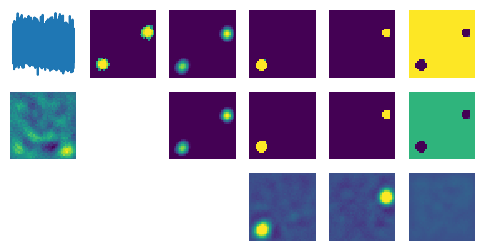

loss 22000 tensor(0.8637, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1101) >>><<
tensor(1.0000e-08) tensor(0.1101) >>><<
tensor(1.0000e-08) tensor(0.1101) >>><<


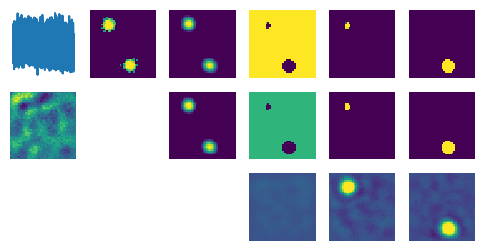

tensor(1.0000e-08) tensor(0.1092) >>><<
tensor(1.0000e-08) tensor(0.1092) >>><<
tensor(1.0000e-08) tensor(0.1092) >>><<


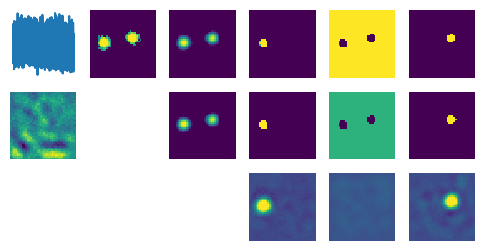

loss 22250 tensor(0.7741, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2130) >>><<
tensor(1.0000e-08) tensor(0.2130) >>><<
tensor(1.0000e-08) tensor(0.2130) >>><<


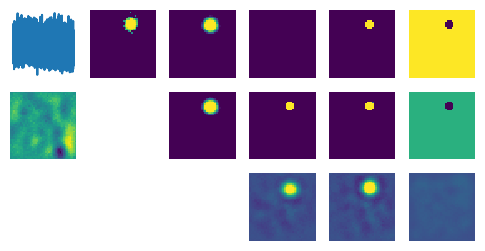

tensor(1.0000e-08) tensor(0.2093) >>><<
tensor(1.0000e-08) tensor(0.2093) >>><<
tensor(1.0000e-08) tensor(0.2093) >>><<


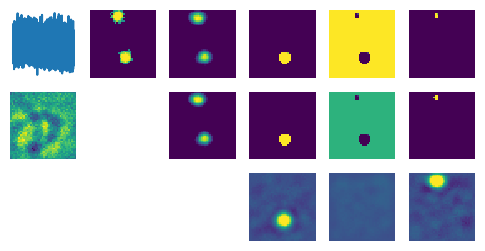

loss 22500 tensor(0.8524, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2568) >>><<
tensor(1.0000e-08) tensor(0.2568) >>><<
tensor(1.0000e-08) tensor(0.2568) >>><<


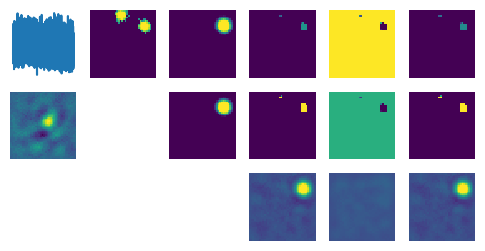

tensor(1.0000e-08) tensor(0.9378) >>><<
tensor(1.0000e-08) tensor(0.9378) >>><<
tensor(1.0000e-08) tensor(0.9378) >>><<


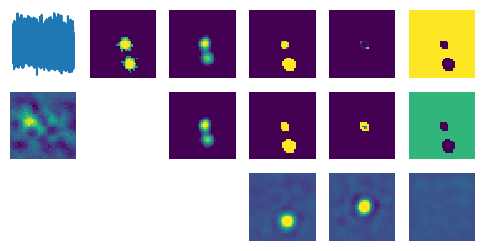

loss 22750 tensor(0.7365, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.9729) >>><<
tensor(1.0000e-08) tensor(0.9729) >>><<
tensor(1.0000e-08) tensor(0.9729) >>><<


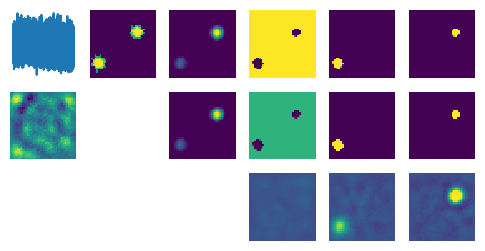

tensor(1.0000e-08) tensor(0.1234) >>><<
tensor(1.0000e-08) tensor(0.1234) >>><<
tensor(1.0000e-08) tensor(0.1234) >>><<


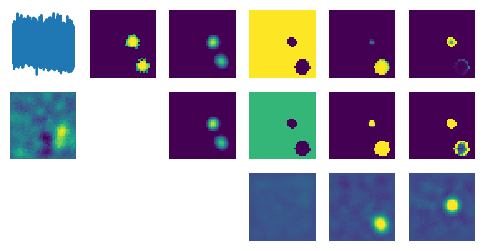

loss 23000 tensor(1.0305, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1388) >>><<
tensor(1.0000e-08) tensor(0.1388) >>><<
tensor(1.0000e-08) tensor(0.1388) >>><<


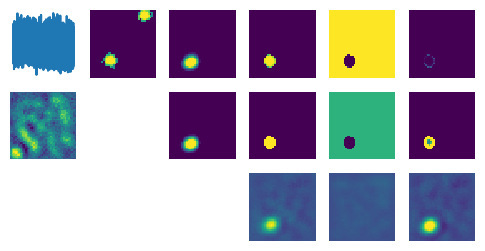

tensor(1.0000e-08) tensor(0.7117) >>><<
tensor(1.0000e-08) tensor(0.7117) >>><<
tensor(1.0000e-08) tensor(0.7117) >>><<


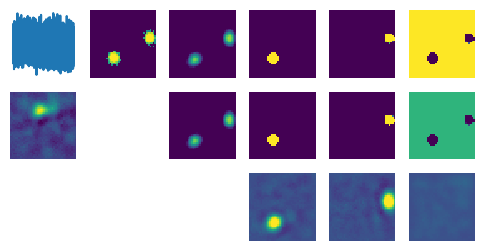

loss 23250 tensor(1.2195, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1966) >>><<
tensor(1.0000e-08) tensor(0.1966) >>><<
tensor(1.0000e-08) tensor(0.1966) >>><<


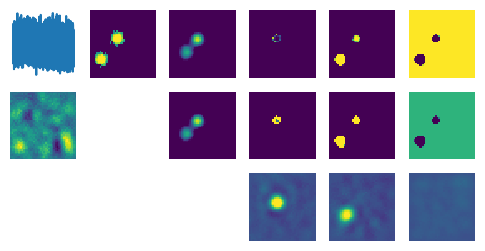

tensor(1.0000e-08) tensor(0.1179) >>><<
tensor(1.0000e-08) tensor(0.1179) >>><<
tensor(1.0000e-08) tensor(0.1179) >>><<


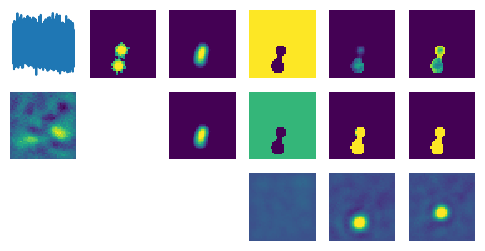

loss 23500 tensor(1.0085, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0982) >>><<
tensor(1.0000e-08) tensor(0.0982) >>><<
tensor(1.0000e-08) tensor(0.0982) >>><<


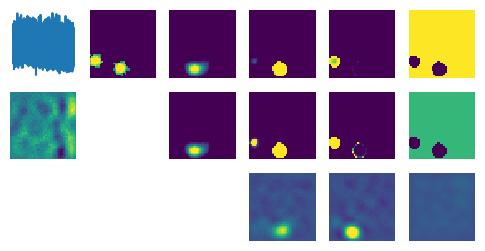

tensor(1.0000e-08) tensor(0.1191) >>><<
tensor(1.0000e-08) tensor(0.1191) >>><<
tensor(1.0000e-08) tensor(0.1191) >>><<


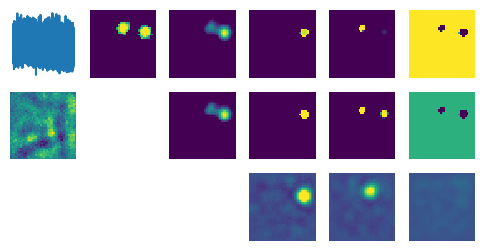

loss 23750 tensor(1.1745, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1098) >>><<
tensor(1.0000e-08) tensor(0.1098) >>><<
tensor(1.0000e-08) tensor(0.1098) >>><<


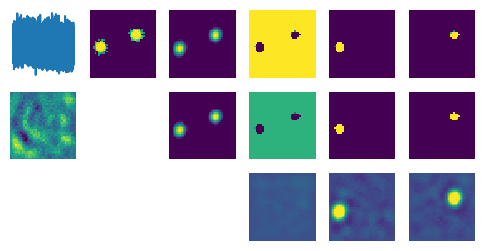

tensor(1.0000e-08) tensor(0.1147) >>><<
tensor(1.0000e-08) tensor(0.1147) >>><<
tensor(1.0000e-08) tensor(0.1147) >>><<


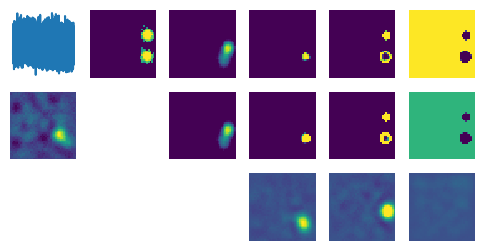

loss 24000 tensor(0.9255, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2049) >>><<
tensor(1.0000e-08) tensor(0.2049) >>><<
tensor(1.0000e-08) tensor(0.2049) >>><<


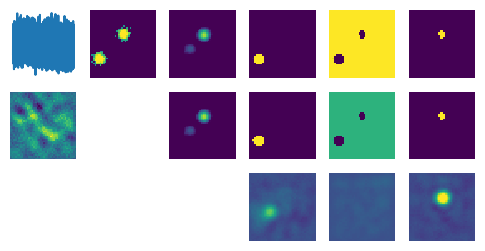

tensor(1.0000e-08) tensor(0.3027) >>><<
tensor(1.0000e-08) tensor(0.3027) >>><<
tensor(1.0000e-08) tensor(0.3027) >>><<


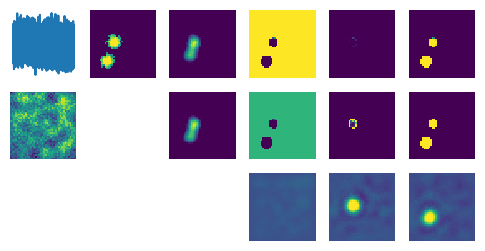

loss 24250 tensor(1.1437, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4204) >>><<
tensor(1.0000e-08) tensor(0.4204) >>><<
tensor(1.0000e-08) tensor(0.4204) >>><<


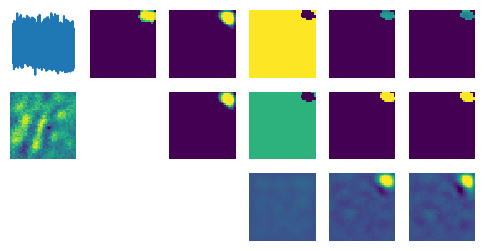

tensor(1.0000e-08) tensor(0.4565) >>><<
tensor(1.0000e-08) tensor(0.4565) >>><<
tensor(1.0000e-08) tensor(0.4565) >>><<


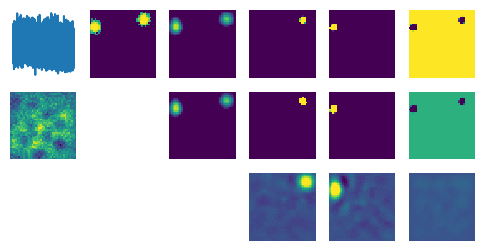

loss 24500 tensor(0.6009, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3452) >>><<
tensor(1.0000e-08) tensor(0.3452) >>><<
tensor(1.0000e-08) tensor(0.3452) >>><<


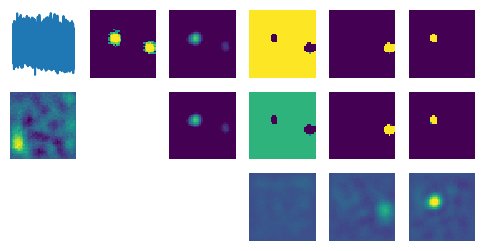

tensor(1.0000e-08) tensor(0.1398) >>><<
tensor(1.0000e-08) tensor(0.1398) >>><<
tensor(1.0000e-08) tensor(0.1398) >>><<


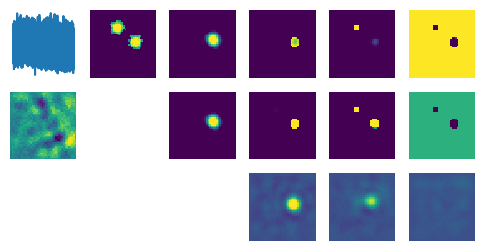

loss 24750 tensor(0.9368, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1628) >>><<
tensor(1.0000e-08) tensor(0.1628) >>><<
tensor(1.0000e-08) tensor(0.1628) >>><<


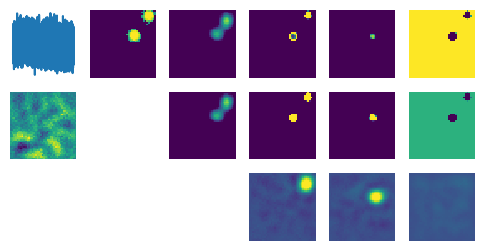

tensor(1.0000e-08) tensor(0.1539) >>><<
tensor(1.0000e-08) tensor(0.1539) >>><<
tensor(1.0000e-08) tensor(0.1539) >>><<


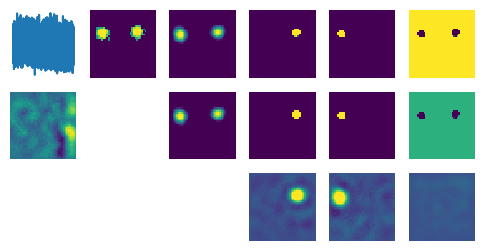

loss 25000 tensor(0.9769, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5688) >>><<
tensor(1.0000e-08) tensor(0.5688) >>><<
tensor(1.0000e-08) tensor(0.5688) >>><<


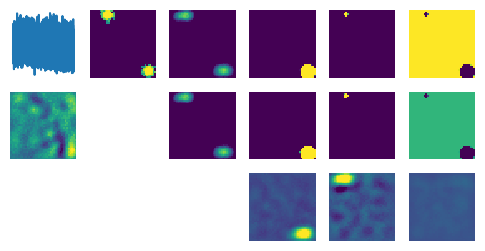

tensor(1.0000e-08) tensor(0.2140) >>><<
tensor(1.0000e-08) tensor(0.2140) >>><<
tensor(1.0000e-08) tensor(0.2140) >>><<


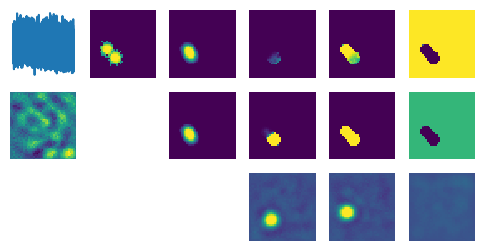

loss 25250 tensor(0.6747, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1667) >>><<
tensor(1.0000e-08) tensor(0.1667) >>><<
tensor(1.0000e-08) tensor(0.1667) >>><<


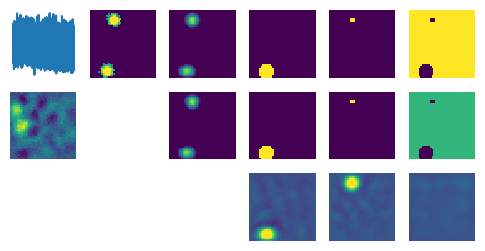

tensor(1.0000e-08) tensor(0.1667) >>><<
tensor(1.0000e-08) tensor(0.1667) >>><<
tensor(1.0000e-08) tensor(0.1667) >>><<


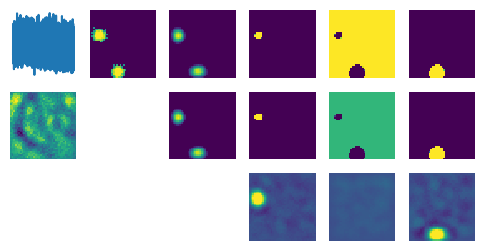

loss 25500 tensor(1.0663, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.6893) >>><<
tensor(1.0000e-08) tensor(0.6893) >>><<
tensor(1.0000e-08) tensor(0.6893) >>><<


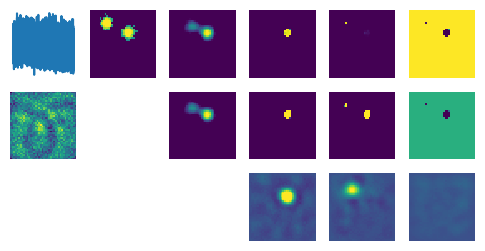

tensor(1.0000e-08) tensor(0.1830) >>><<
tensor(1.0000e-08) tensor(0.1830) >>><<
tensor(1.0000e-08) tensor(0.1830) >>><<


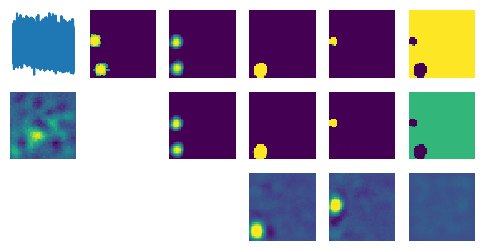

loss 25750 tensor(1.1080, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2060) >>><<
tensor(1.0000e-08) tensor(0.2060) >>><<
tensor(1.0000e-08) tensor(0.2060) >>><<


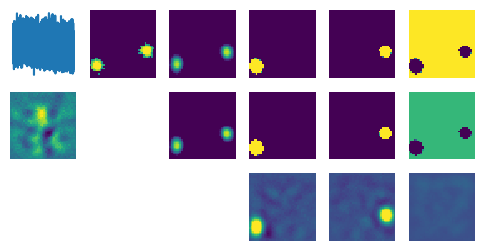

tensor(1.0000e-08) tensor(0.1577) >>><<
tensor(1.0000e-08) tensor(0.1577) >>><<
tensor(1.0000e-08) tensor(0.1577) >>><<


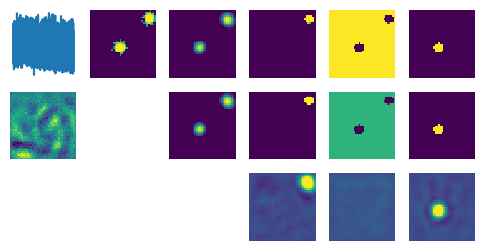

loss 26000 tensor(1.0099, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0844) >>><<
tensor(1.0000e-08) tensor(0.0844) >>><<
tensor(1.0000e-08) tensor(0.0844) >>><<


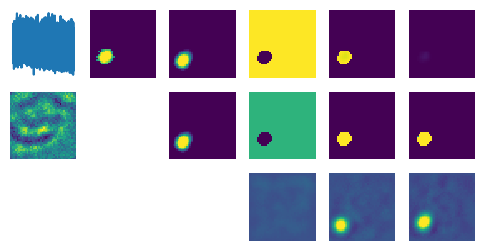

tensor(1.0000e-08) tensor(0.3438) >>><<
tensor(1.0000e-08) tensor(0.3438) >>><<
tensor(1.0000e-08) tensor(0.3438) >>><<


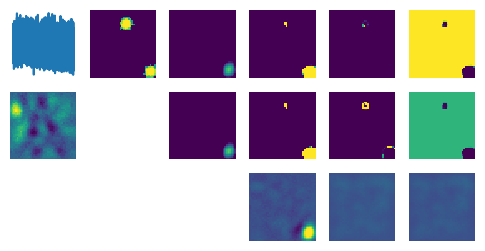

loss 26250 tensor(1.5736, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3647) >>><<
tensor(1.0000e-08) tensor(0.3647) >>><<
tensor(1.0000e-08) tensor(0.3647) >>><<


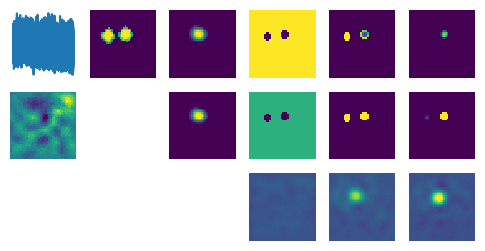

tensor(1.0000e-08) tensor(0.1195) >>><<
tensor(1.0000e-08) tensor(0.1195) >>><<
tensor(1.0000e-08) tensor(0.1195) >>><<


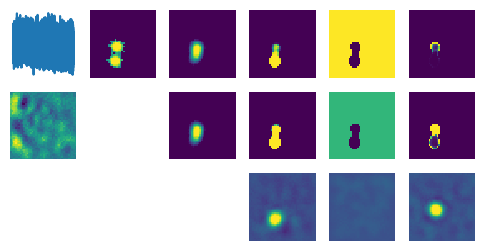

loss 26500 tensor(1.0096, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.9996) >>><<
tensor(1.0000e-08) tensor(0.9996) >>><<
tensor(1.0000e-08) tensor(0.9996) >>><<


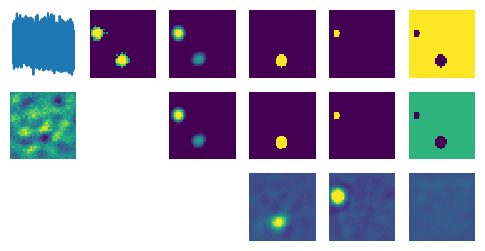

tensor(1.0000e-08) tensor(0.2273) >>><<
tensor(1.0000e-08) tensor(0.2273) >>><<
tensor(1.0000e-08) tensor(0.2273) >>><<


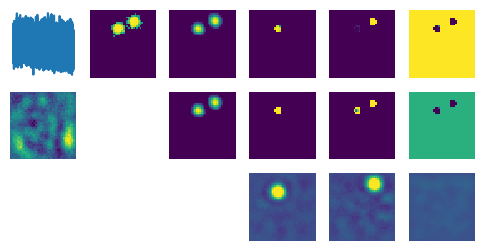

loss 26750 tensor(0.6945, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2900) >>><<
tensor(1.0000e-08) tensor(0.2900) >>><<
tensor(1.0000e-08) tensor(0.2900) >>><<


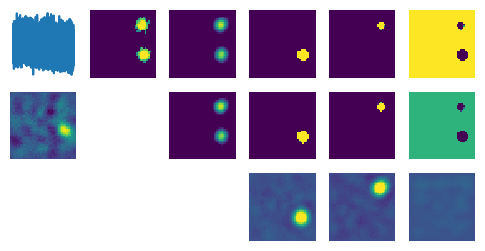

tensor(1.0000e-08) tensor(0.3181) >>><<
tensor(1.0000e-08) tensor(0.3181) >>><<
tensor(1.0000e-08) tensor(0.3181) >>><<


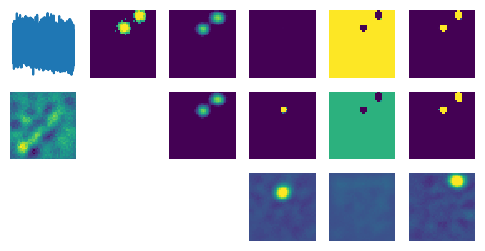

loss 27000 tensor(1.2803, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0879) >>><<
tensor(1.0000e-08) tensor(0.0879) >>><<
tensor(1.0000e-08) tensor(0.0879) >>><<


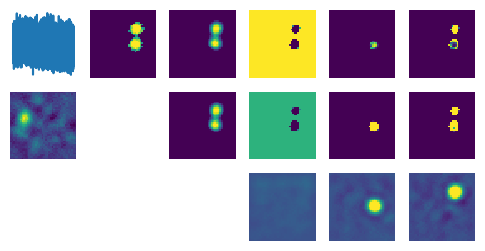

tensor(1.0000e-08) tensor(0.0833) >>><<
tensor(1.0000e-08) tensor(0.0833) >>><<
tensor(1.0000e-08) tensor(0.0833) >>><<


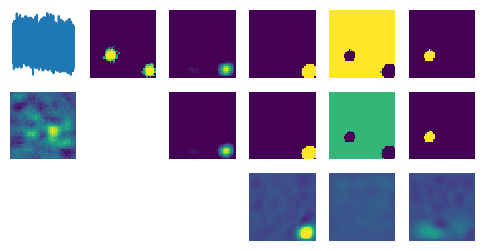

loss 27250 tensor(1.2332, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2196) >>><<
tensor(1.0000e-08) tensor(0.2196) >>><<
tensor(1.0000e-08) tensor(0.2196) >>><<


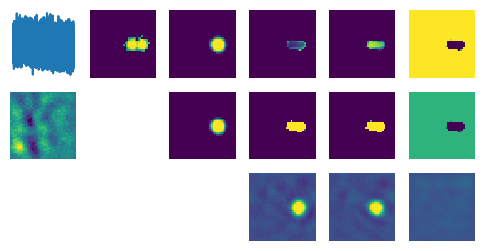

tensor(1.0000e-08) tensor(0.1250) >>><<
tensor(1.0000e-08) tensor(0.1250) >>><<
tensor(1.0000e-08) tensor(0.1250) >>><<


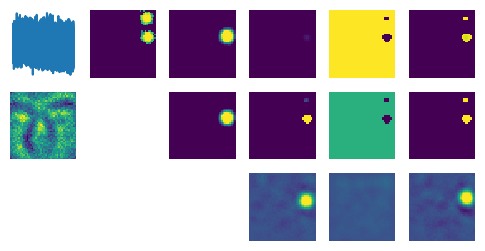

loss 27500 tensor(1.0948, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2512) >>><<
tensor(1.0000e-08) tensor(0.2512) >>><<
tensor(1.0000e-08) tensor(0.2512) >>><<


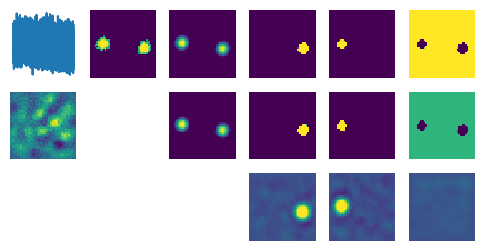

tensor(1.0000e-08) tensor(0.1199) >>><<
tensor(1.0000e-08) tensor(0.1199) >>><<
tensor(1.0000e-08) tensor(0.1199) >>><<


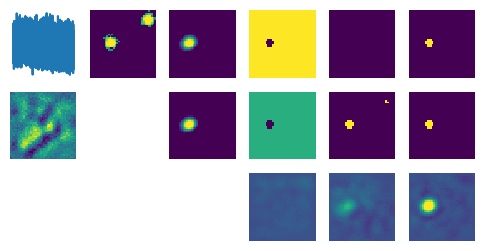

loss 27750 tensor(0.9556, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1065) >>><<
tensor(1.0000e-08) tensor(0.1065) >>><<
tensor(1.0000e-08) tensor(0.1065) >>><<


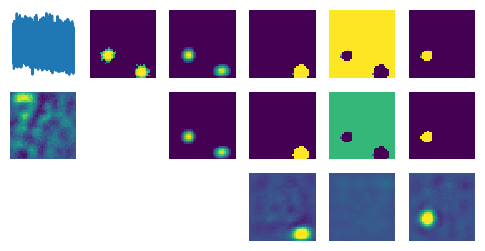

tensor(1.0000e-08) tensor(0.0714) >>><<
tensor(1.0000e-08) tensor(0.0714) >>><<
tensor(1.0000e-08) tensor(0.0714) >>><<


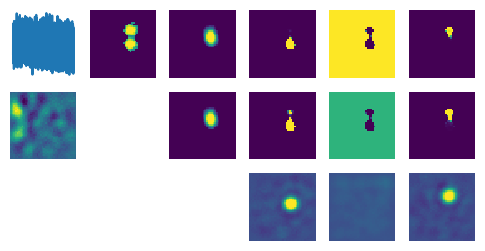

loss 28000 tensor(1.2317, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1269) >>><<
tensor(1.0000e-08) tensor(0.1269) >>><<
tensor(1.0000e-08) tensor(0.1269) >>><<


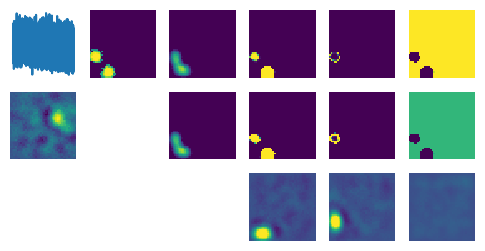

tensor(1.0000e-08) tensor(0.2567) >>><<
tensor(1.0000e-08) tensor(0.2567) >>><<
tensor(1.0000e-08) tensor(0.2567) >>><<


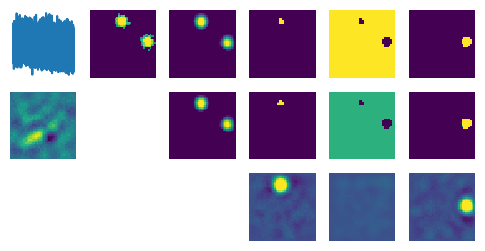

loss 28250 tensor(1.0109, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2497) >>><<
tensor(1.0000e-08) tensor(0.2497) >>><<
tensor(1.0000e-08) tensor(0.2497) >>><<


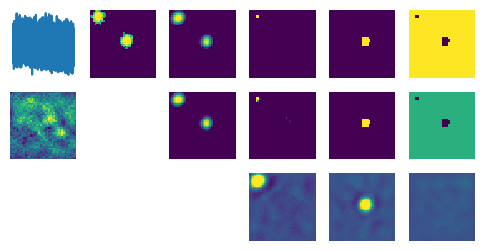

tensor(1.0000e-08) tensor(0.2080) >>><<
tensor(1.0000e-08) tensor(0.2080) >>><<
tensor(1.0000e-08) tensor(0.2080) >>><<


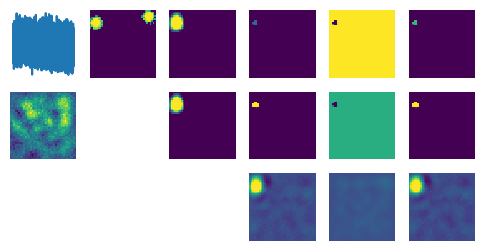

loss 28500 tensor(0.7540, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2392) >>><<
tensor(1.0000e-08) tensor(0.2392) >>><<
tensor(1.0000e-08) tensor(0.2392) >>><<


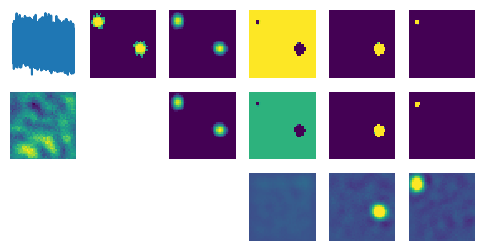

tensor(1.0000e-08) tensor(0.7323) >>><<
tensor(1.0000e-08) tensor(0.7323) >>><<
tensor(1.0000e-08) tensor(0.7323) >>><<


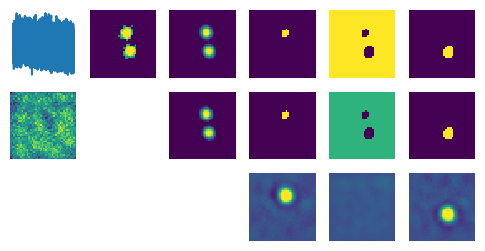

loss 28750 tensor(1.0077, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4808) >>><<
tensor(1.0000e-08) tensor(0.4808) >>><<
tensor(1.0000e-08) tensor(0.4808) >>><<


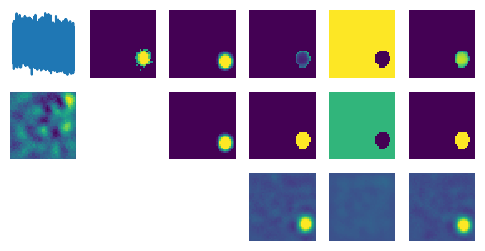

tensor(1.0000e-08) tensor(0.3060) >>><<
tensor(1.0000e-08) tensor(0.3060) >>><<
tensor(1.0000e-08) tensor(0.3060) >>><<


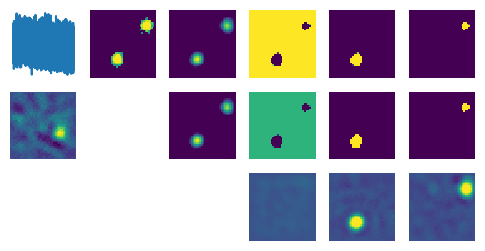

loss 29000 tensor(0.8433, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0588) >>><<
tensor(1.0000e-08) tensor(0.0588) >>><<
tensor(1.0000e-08) tensor(0.0588) >>><<


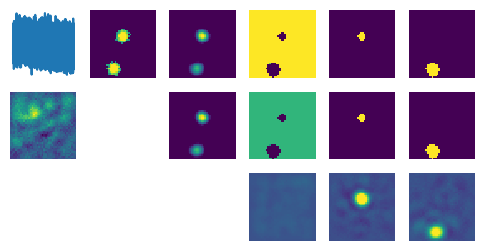

tensor(1.0000e-08) tensor(0.1460) >>><<
tensor(1.0000e-08) tensor(0.1460) >>><<
tensor(1.0000e-08) tensor(0.1460) >>><<


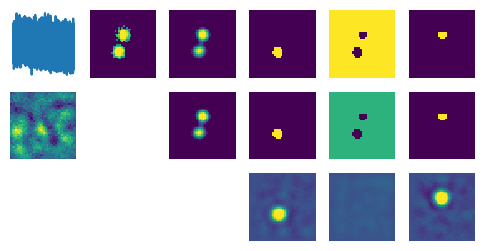

loss 29250 tensor(0.9661, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0677) >>><<
tensor(1.0000e-08) tensor(0.0677) >>><<
tensor(1.0000e-08) tensor(0.0677) >>><<


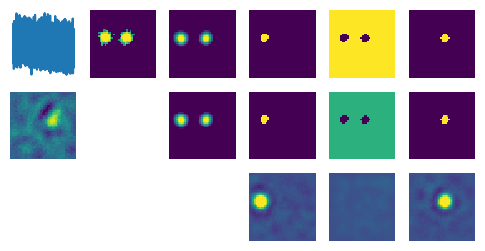

tensor(1.0000e-08) tensor(0.0997) >>><<
tensor(1.0000e-08) tensor(0.0997) >>><<
tensor(1.0000e-08) tensor(0.0997) >>><<


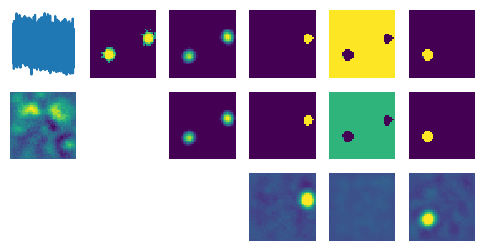

loss 29500 tensor(0.7788, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4188) >>><<
tensor(1.0000e-08) tensor(0.4188) >>><<
tensor(1.0000e-08) tensor(0.4188) >>><<


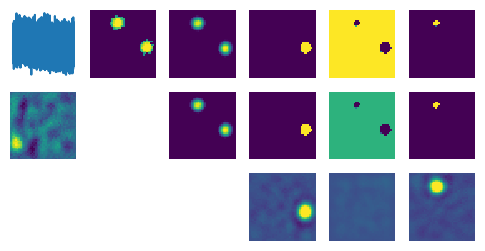

tensor(1.0000e-08) tensor(0.2930) >>><<
tensor(1.0000e-08) tensor(0.2930) >>><<
tensor(1.0000e-08) tensor(0.2930) >>><<


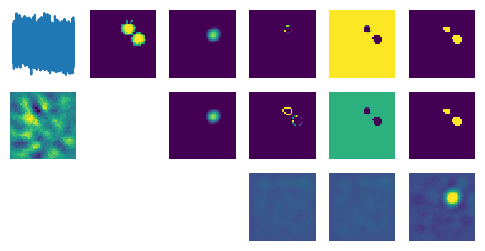

loss 29750 tensor(0.6622, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0912) >>><<
tensor(1.0000e-08) tensor(0.0912) >>><<
tensor(1.0000e-08) tensor(0.0912) >>><<


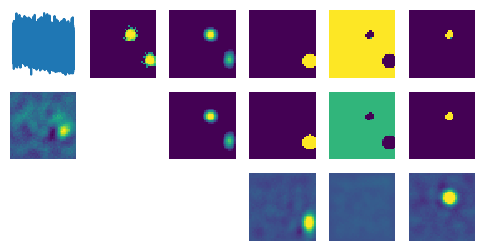

tensor(1.0000e-08) tensor(0.0943) >>><<
tensor(1.0000e-08) tensor(0.0943) >>><<
tensor(1.0000e-08) tensor(0.0943) >>><<


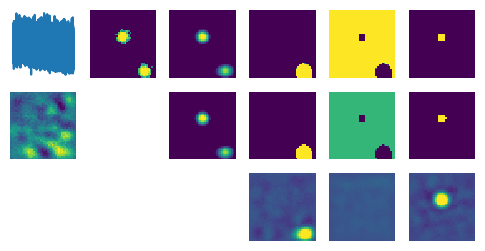

loss 30000 tensor(0.6557, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0996) >>><<
tensor(1.0000e-08) tensor(0.0996) >>><<
tensor(1.0000e-08) tensor(0.0996) >>><<


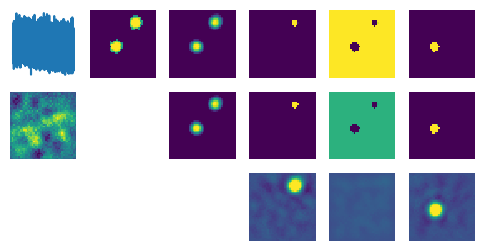

tensor(1.0000e-08) tensor(0.1114) >>><<
tensor(1.0000e-08) tensor(0.1114) >>><<
tensor(1.0000e-08) tensor(0.1114) >>><<


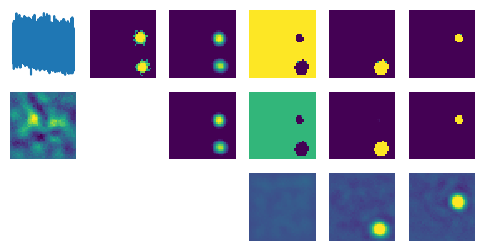

loss 30250 tensor(1.2338, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1203) >>><<
tensor(1.0000e-08) tensor(0.1203) >>><<
tensor(1.0000e-08) tensor(0.1203) >>><<


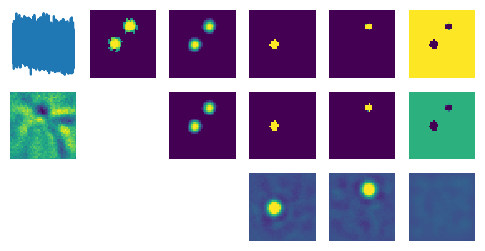

tensor(1.0000e-08) tensor(0.2078) >>><<
tensor(1.0000e-08) tensor(0.2078) >>><<
tensor(1.0000e-08) tensor(0.2078) >>><<


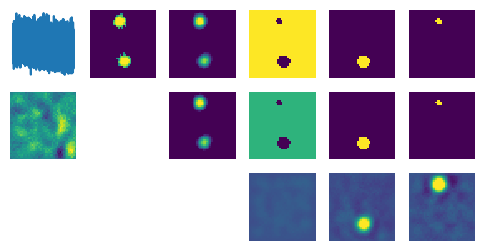

loss 30500 tensor(0.6274, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1115) >>><<
tensor(1.0000e-08) tensor(0.1115) >>><<
tensor(1.0000e-08) tensor(0.1115) >>><<


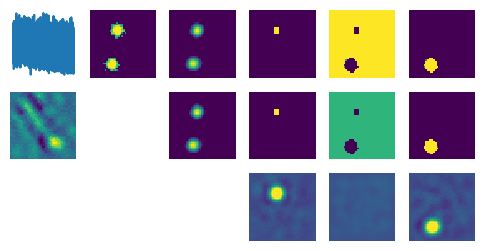

tensor(1.0000e-08) tensor(0.1020) >>><<
tensor(1.0000e-08) tensor(0.1020) >>><<
tensor(1.0000e-08) tensor(0.1020) >>><<


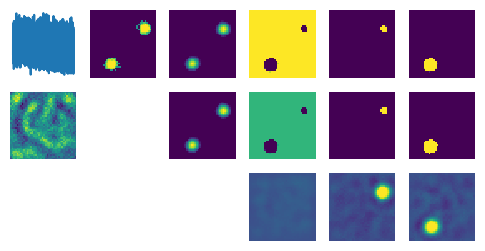

loss 30750 tensor(0.6235, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0762) >>><<
tensor(1.0000e-08) tensor(0.0762) >>><<
tensor(1.0000e-08) tensor(0.0762) >>><<


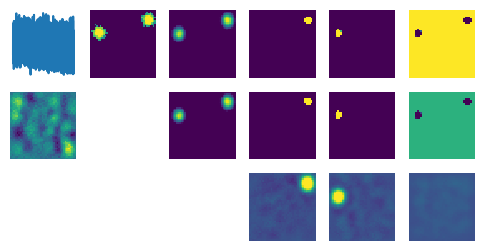

tensor(1.0000e-08) tensor(0.0624) >>><<
tensor(1.0000e-08) tensor(0.0624) >>><<
tensor(1.0000e-08) tensor(0.0624) >>><<


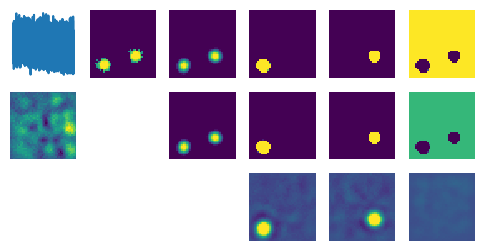

loss 31000 tensor(0.7640, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0795) >>><<
tensor(1.0000e-08) tensor(0.0795) >>><<
tensor(1.0000e-08) tensor(0.0795) >>><<


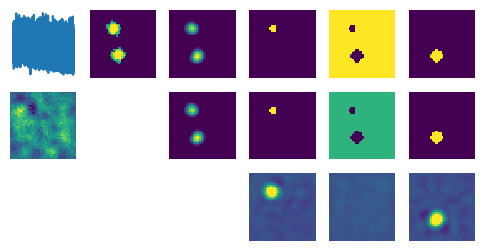

tensor(1.0000e-08) tensor(0.0894) >>><<
tensor(1.0000e-08) tensor(0.0894) >>><<
tensor(1.0000e-08) tensor(0.0894) >>><<


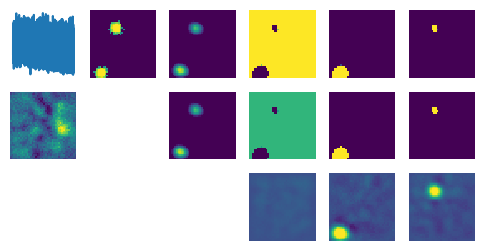

loss 31250 tensor(1.0868, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4724) >>><<
tensor(1.0000e-08) tensor(0.4724) >>><<
tensor(1.0000e-08) tensor(0.4724) >>><<


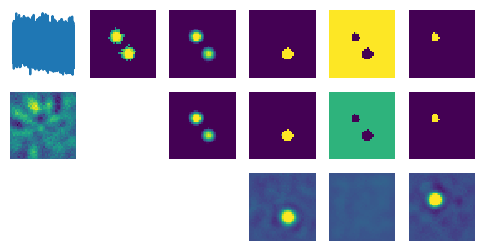

tensor(1.0000e-08) tensor(0.5722) >>><<
tensor(1.0000e-08) tensor(0.5722) >>><<
tensor(1.0000e-08) tensor(0.5722) >>><<


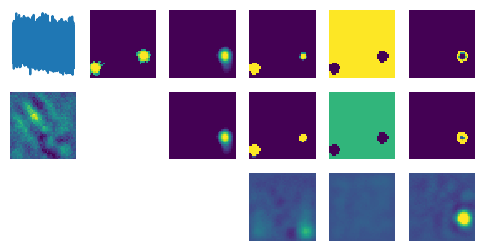

loss 31500 tensor(1.1571, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1250) >>><<
tensor(1.0000e-08) tensor(0.1250) >>><<
tensor(1.0000e-08) tensor(0.1250) >>><<


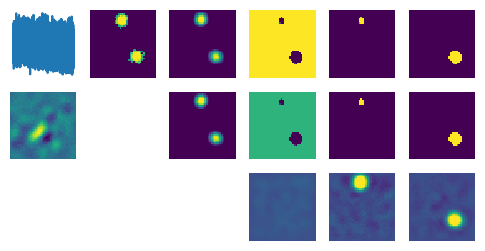

tensor(1.0000e-08) tensor(0.1250) >>><<
tensor(1.0000e-08) tensor(0.1250) >>><<
tensor(1.0000e-08) tensor(0.1250) >>><<


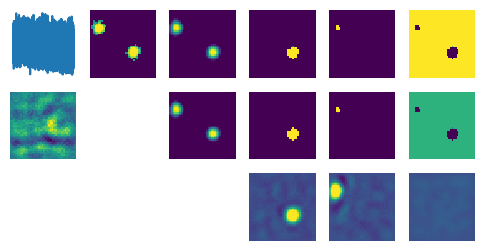

loss 31750 tensor(0.8901, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.8234) >>><<
tensor(1.0000e-08) tensor(0.8234) >>><<
tensor(1.0000e-08) tensor(0.8234) >>><<


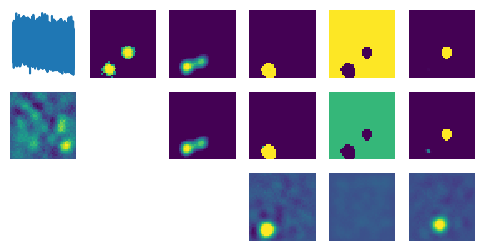

tensor(1.0000e-08) tensor(0.3913) >>><<
tensor(1.0000e-08) tensor(0.3913) >>><<
tensor(1.0000e-08) tensor(0.3913) >>><<


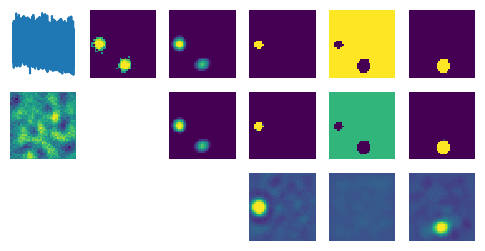

loss 32000 tensor(1.7294, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1415) >>><<
tensor(1.0000e-08) tensor(0.1415) >>><<
tensor(1.0000e-08) tensor(0.1415) >>><<


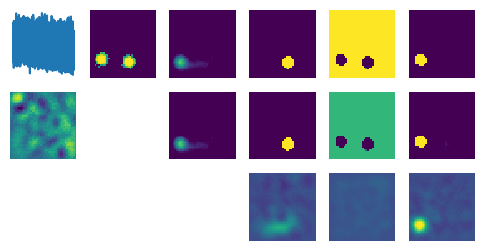

tensor(1.0000e-08) tensor(0.0832) >>><<
tensor(1.0000e-08) tensor(0.0832) >>><<
tensor(1.0000e-08) tensor(0.0832) >>><<


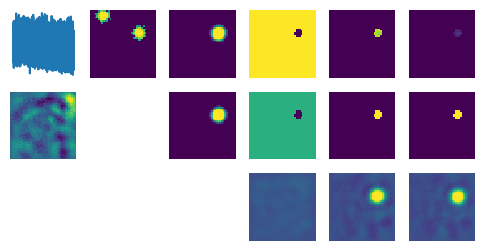

loss 32250 tensor(0.8472, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0814) >>><<
tensor(1.0000e-08) tensor(0.0814) >>><<
tensor(1.0000e-08) tensor(0.0814) >>><<


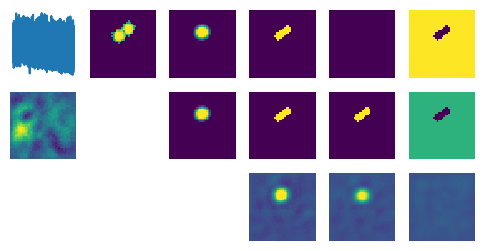

tensor(1.0000e-08) tensor(0.2842) >>><<
tensor(1.0000e-08) tensor(0.2842) >>><<
tensor(1.0000e-08) tensor(0.2842) >>><<


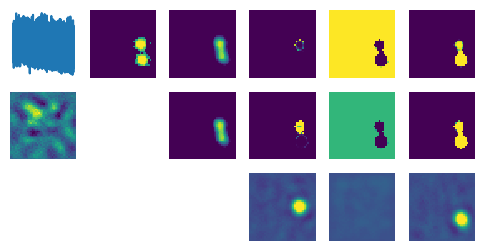

loss 32500 tensor(0.5591, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0714) >>><<
tensor(1.0000e-08) tensor(0.0714) >>><<
tensor(1.0000e-08) tensor(0.0714) >>><<


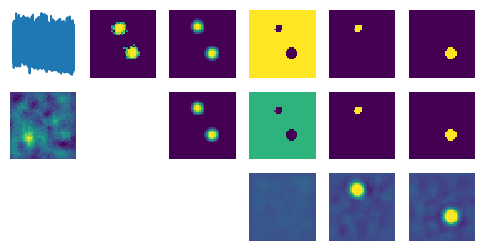

tensor(1.0000e-08) tensor(0.0923) >>><<
tensor(1.0000e-08) tensor(0.0923) >>><<
tensor(1.0000e-08) tensor(0.0923) >>><<


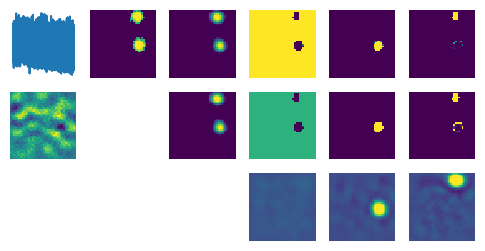

loss 32750 tensor(0.8887, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1429) >>><<
tensor(1.0000e-08) tensor(0.1429) >>><<
tensor(1.0000e-08) tensor(0.1429) >>><<


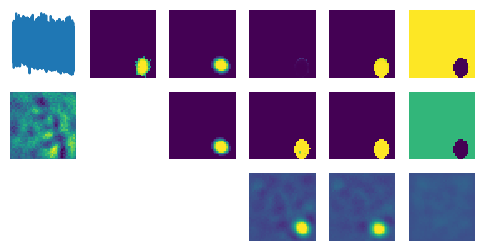

tensor(1.0000e-08) tensor(0.1946) >>><<
tensor(1.0000e-08) tensor(0.1946) >>><<
tensor(1.0000e-08) tensor(0.1946) >>><<


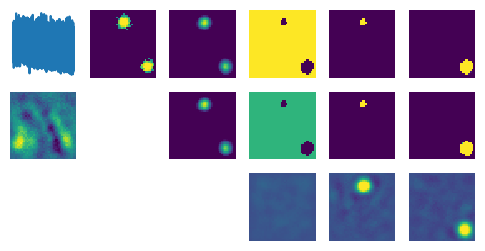

loss 33000 tensor(0.8416, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1594) >>><<
tensor(1.0000e-08) tensor(0.1594) >>><<
tensor(1.0000e-08) tensor(0.1594) >>><<


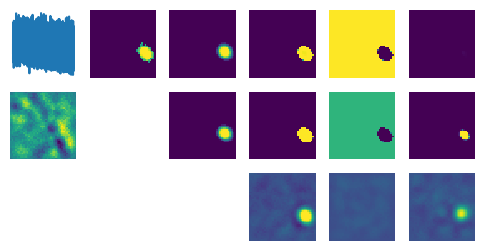

tensor(1.0000e-08) tensor(0.1697) >>><<
tensor(1.0000e-08) tensor(0.1697) >>><<
tensor(1.0000e-08) tensor(0.1697) >>><<


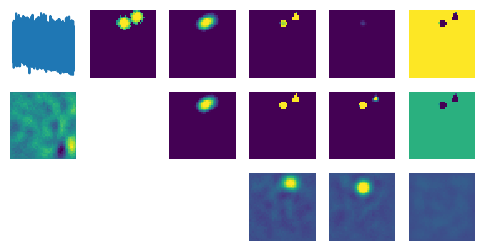

loss 33250 tensor(0.6515, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1076) >>><<
tensor(1.0000e-08) tensor(0.1076) >>><<
tensor(1.0000e-08) tensor(0.1076) >>><<


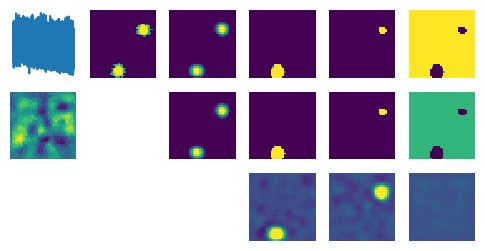

tensor(1.0000e-08) tensor(0.1100) >>><<
tensor(1.0000e-08) tensor(0.1100) >>><<
tensor(1.0000e-08) tensor(0.1100) >>><<


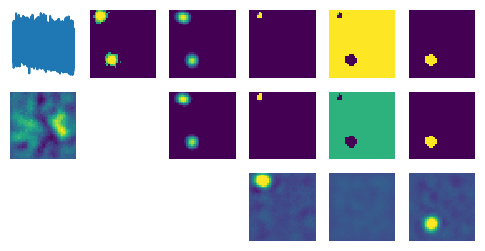

loss 33500 tensor(1.7965, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3677) >>><<
tensor(1.0000e-08) tensor(0.3677) >>><<
tensor(1.0000e-08) tensor(0.3677) >>><<


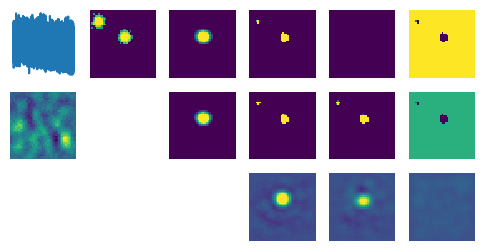

tensor(1.0000e-08) tensor(0.1615) >>><<
tensor(1.0000e-08) tensor(0.1615) >>><<
tensor(1.0000e-08) tensor(0.1615) >>><<


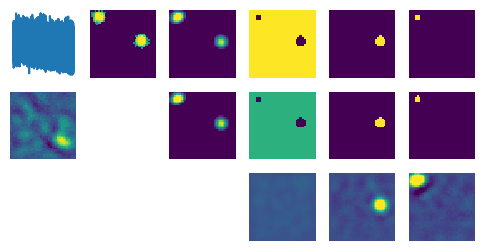

loss 33750 tensor(1.0861, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0721) >>><<
tensor(1.0000e-08) tensor(0.0721) >>><<
tensor(1.0000e-08) tensor(0.0721) >>><<


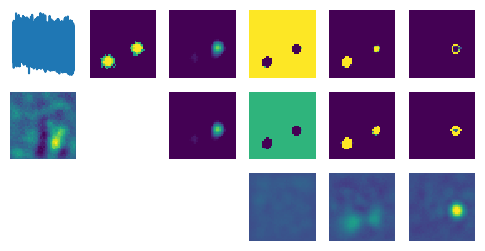

tensor(1.0000e-08) tensor(0.0500) >>><<
tensor(1.0000e-08) tensor(0.0500) >>><<
tensor(1.0000e-08) tensor(0.0500) >>><<


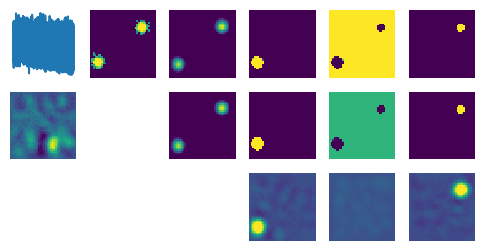

loss 34000 tensor(0.8145, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0714) >>><<
tensor(1.0000e-08) tensor(0.0714) >>><<
tensor(1.0000e-08) tensor(0.0714) >>><<


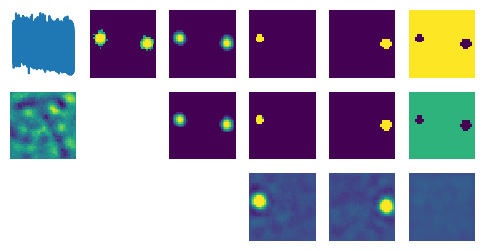

tensor(1.0000e-08) tensor(0.0908) >>><<
tensor(1.0000e-08) tensor(0.0908) >>><<
tensor(1.0000e-08) tensor(0.0908) >>><<


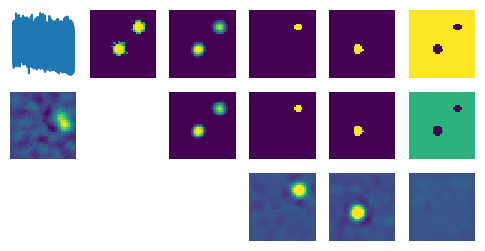

loss 34250 tensor(0.7710, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2381) >>><<
tensor(1.0000e-08) tensor(0.2381) >>><<
tensor(1.0000e-08) tensor(0.2381) >>><<


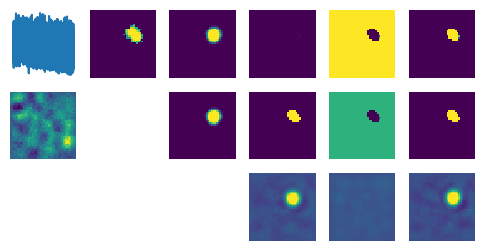

tensor(1.0000e-08) tensor(0.1803) >>><<
tensor(1.0000e-08) tensor(0.1803) >>><<
tensor(1.0000e-08) tensor(0.1803) >>><<


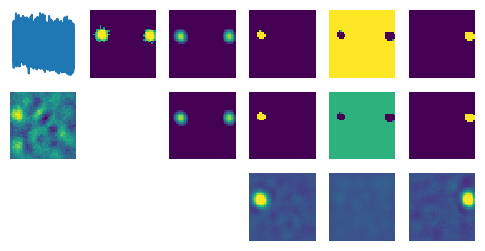

loss 34500 tensor(0.6410, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0564) >>><<
tensor(1.0000e-08) tensor(0.0564) >>><<
tensor(1.0000e-08) tensor(0.0564) >>><<


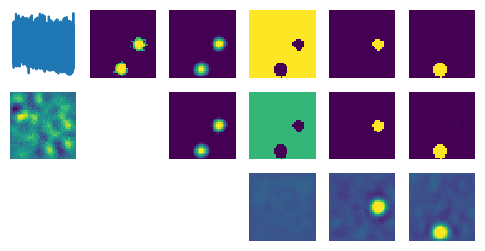

tensor(1.0000e-08) tensor(0.0585) >>><<
tensor(1.0000e-08) tensor(0.0585) >>><<
tensor(1.0000e-08) tensor(0.0585) >>><<


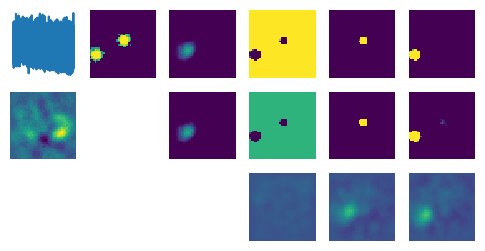

loss 34750 tensor(0.6427, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1213) >>><<
tensor(1.0000e-08) tensor(0.1213) >>><<
tensor(1.0000e-08) tensor(0.1213) >>><<


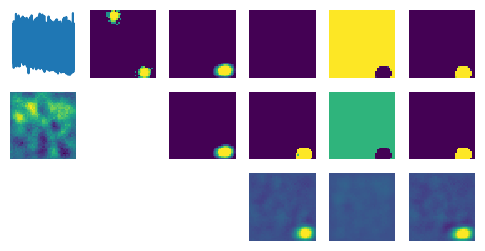

tensor(1.0000e-08) tensor(0.2364) >>><<
tensor(1.0000e-08) tensor(0.2364) >>><<
tensor(1.0000e-08) tensor(0.2364) >>><<


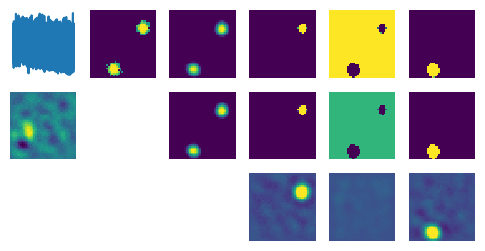

loss 35000 tensor(0.8784, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1002) >>><<
tensor(1.0000e-08) tensor(0.1002) >>><<
tensor(1.0000e-08) tensor(0.1002) >>><<


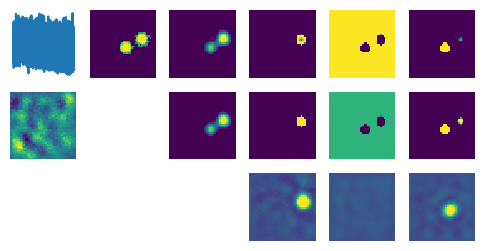

tensor(1.0000e-08) tensor(0.1001) >>><<
tensor(1.0000e-08) tensor(0.1001) >>><<
tensor(1.0000e-08) tensor(0.1001) >>><<


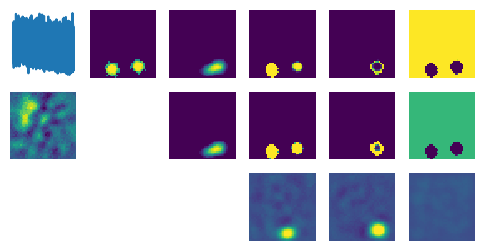

loss 35250 tensor(0.9048, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0834) >>><<
tensor(1.0000e-08) tensor(0.0834) >>><<
tensor(1.0000e-08) tensor(0.0834) >>><<


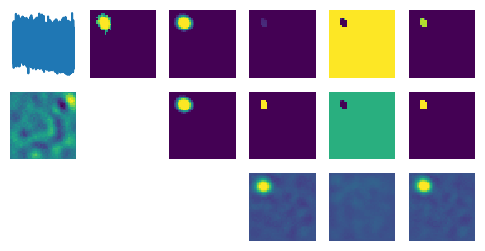

tensor(1.0000e-08) tensor(0.0835) >>><<
tensor(1.0000e-08) tensor(0.0835) >>><<
tensor(1.0000e-08) tensor(0.0835) >>><<


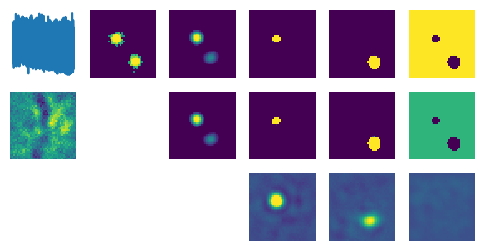

loss 35500 tensor(1.2869, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0980) >>><<
tensor(1.0000e-08) tensor(0.0980) >>><<
tensor(1.0000e-08) tensor(0.0980) >>><<


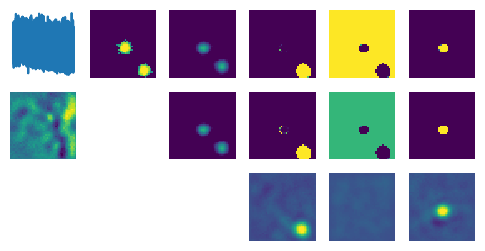

tensor(1.0000e-08) tensor(0.5898) >>><<
tensor(1.0000e-08) tensor(0.5898) >>><<
tensor(1.0000e-08) tensor(0.5898) >>><<


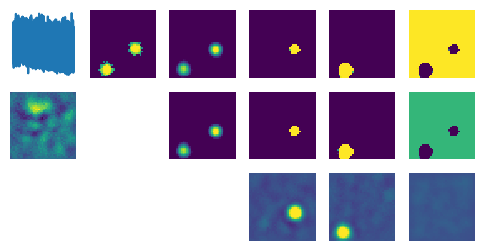

loss 35750 tensor(0.8591, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1357) >>><<
tensor(1.0000e-08) tensor(0.1357) >>><<
tensor(1.0000e-08) tensor(0.1357) >>><<


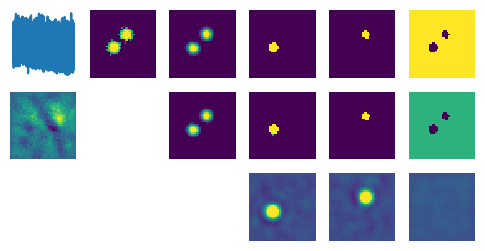

tensor(1.0000e-08) tensor(0.1046) >>><<
tensor(1.0000e-08) tensor(0.1046) >>><<
tensor(1.0000e-08) tensor(0.1046) >>><<


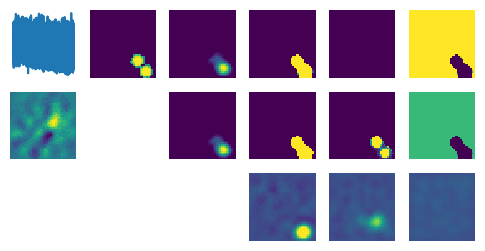

loss 36000 tensor(1.1502, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.6842) >>><<
tensor(1.0000e-08) tensor(0.6842) >>><<
tensor(1.0000e-08) tensor(0.6842) >>><<


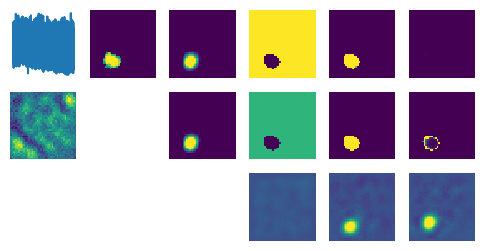

tensor(1.0000e-08) tensor(0.7089) >>><<
tensor(1.0000e-08) tensor(0.7089) >>><<
tensor(1.0000e-08) tensor(0.7089) >>><<


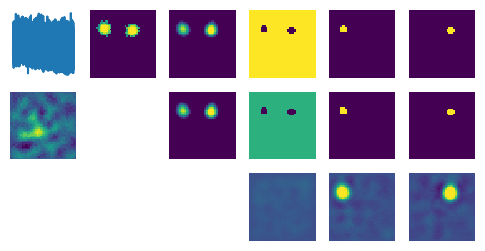

loss 36250 tensor(1.1045, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2676) >>><<
tensor(1.0000e-08) tensor(0.2676) >>><<
tensor(1.0000e-08) tensor(0.2676) >>><<


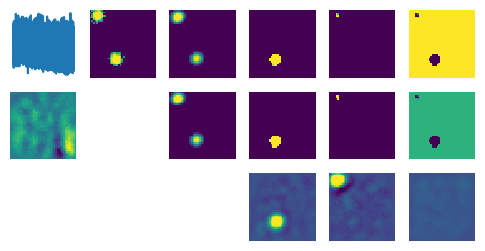

tensor(1.0000e-08) tensor(0.3145) >>><<
tensor(1.0000e-08) tensor(0.3145) >>><<
tensor(1.0000e-08) tensor(0.3145) >>><<


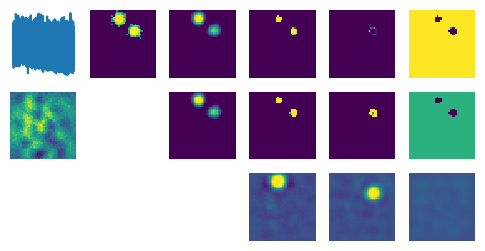

loss 36500 tensor(1.5471, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1306) >>><<
tensor(1.0000e-08) tensor(0.1306) >>><<
tensor(1.0000e-08) tensor(0.1306) >>><<


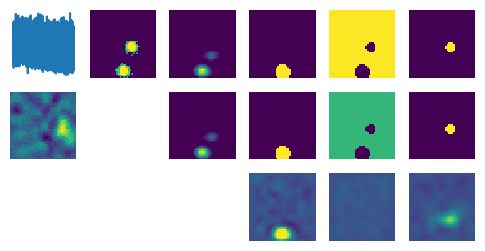

tensor(1.0000e-08) tensor(0.4889) >>><<
tensor(1.0000e-08) tensor(0.4889) >>><<
tensor(1.0000e-08) tensor(0.4889) >>><<


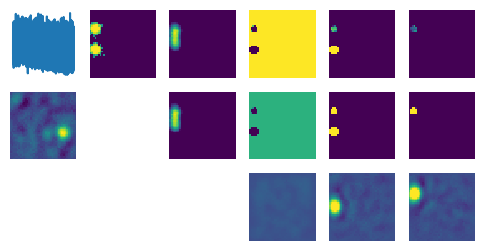

loss 36750 tensor(1.1436, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0690) >>><<
tensor(1.0000e-08) tensor(0.0690) >>><<
tensor(1.0000e-08) tensor(0.0690) >>><<


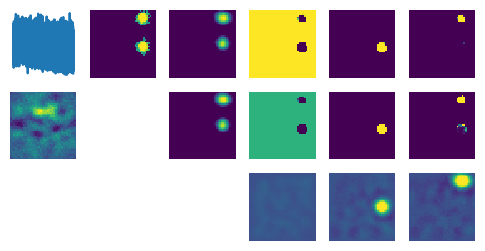

tensor(1.0000e-08) tensor(0.3681) >>><<
tensor(1.0000e-08) tensor(0.3681) >>><<
tensor(1.0000e-08) tensor(0.3681) >>><<


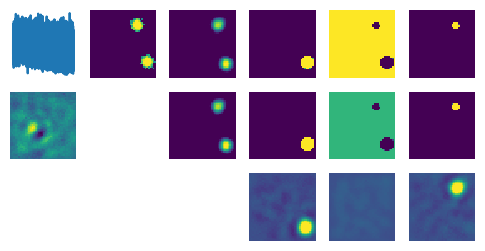

loss 37000 tensor(1.5393, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5537) >>><<
tensor(1.0000e-08) tensor(0.5537) >>><<
tensor(1.0000e-08) tensor(0.5537) >>><<


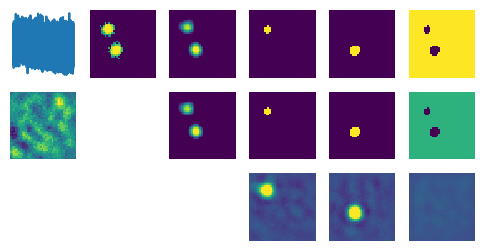

tensor(1.0000e-08) tensor(0.2935) >>><<
tensor(1.0000e-08) tensor(0.2935) >>><<
tensor(1.0000e-08) tensor(0.2935) >>><<


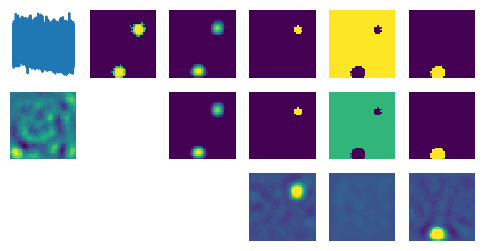

loss 37250 tensor(1.0424, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2823) >>><<
tensor(1.0000e-08) tensor(0.2823) >>><<
tensor(1.0000e-08) tensor(0.2823) >>><<


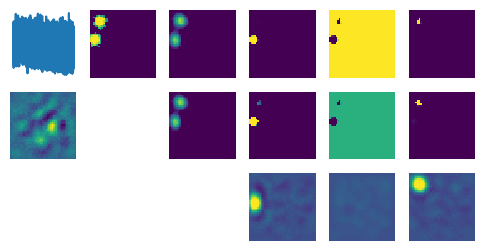

tensor(1.0000e-08) tensor(0.4584) >>><<
tensor(1.0000e-08) tensor(0.4584) >>><<
tensor(1.0000e-08) tensor(0.4584) >>><<


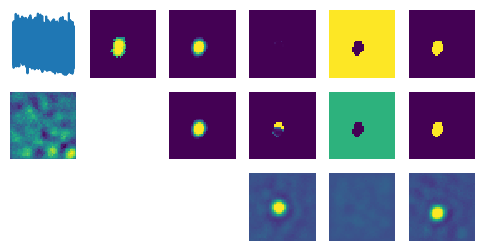

loss 37500 tensor(1.0824, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1523) >>><<
tensor(1.0000e-08) tensor(0.1523) >>><<
tensor(1.0000e-08) tensor(0.1523) >>><<


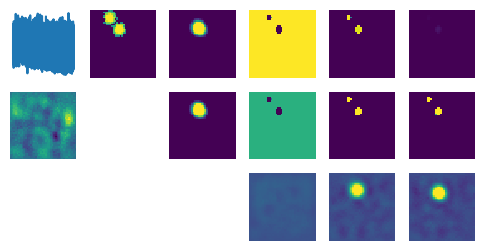

tensor(1.0000e-08) tensor(0.2936) >>><<
tensor(1.0000e-08) tensor(0.2936) >>><<
tensor(1.0000e-08) tensor(0.2936) >>><<


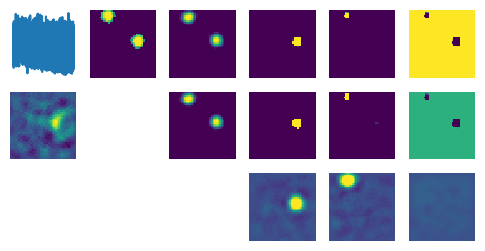

loss 37750 tensor(1.1804, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2522) >>><<
tensor(1.0000e-08) tensor(0.2522) >>><<
tensor(1.0000e-08) tensor(0.2522) >>><<


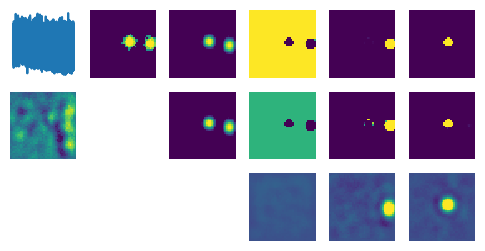

tensor(1.0000e-08) tensor(0.0952) >>><<
tensor(1.0000e-08) tensor(0.0952) >>><<
tensor(1.0000e-08) tensor(0.0952) >>><<


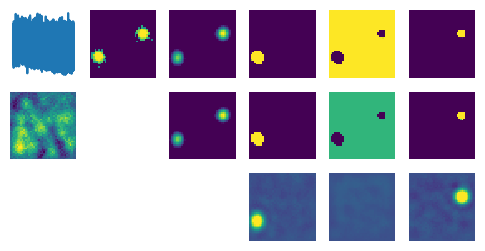

loss 38000 tensor(0.7879, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1115) >>><<
tensor(1.0000e-08) tensor(0.1115) >>><<
tensor(1.0000e-08) tensor(0.1115) >>><<


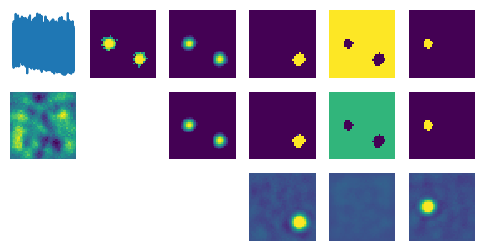

tensor(1.0000e-08) tensor(0.1765) >>><<
tensor(1.0000e-08) tensor(0.1765) >>><<
tensor(1.0000e-08) tensor(0.1765) >>><<


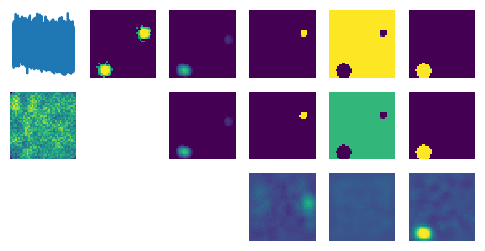

loss 38250 tensor(0.8794, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3390) >>><<
tensor(1.0000e-08) tensor(0.3390) >>><<
tensor(1.0000e-08) tensor(0.3390) >>><<


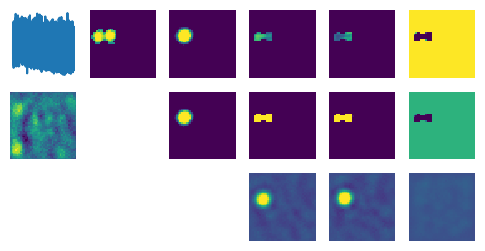

tensor(1.0000e-08) tensor(0.1501) >>><<
tensor(1.0000e-08) tensor(0.1501) >>><<
tensor(1.0000e-08) tensor(0.1501) >>><<


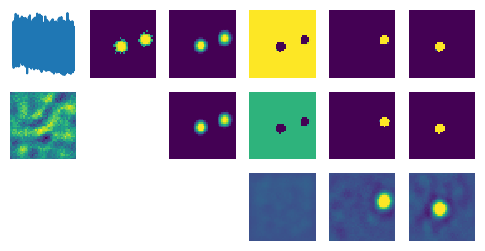

loss 38500 tensor(1.2106, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2671) >>><<
tensor(1.0000e-08) tensor(0.2671) >>><<
tensor(1.0000e-08) tensor(0.2671) >>><<


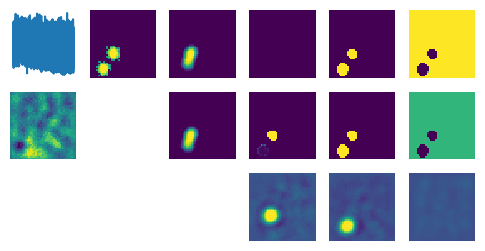

tensor(1.0000e-08) tensor(0.1899) >>><<
tensor(1.0000e-08) tensor(0.1899) >>><<
tensor(1.0000e-08) tensor(0.1899) >>><<


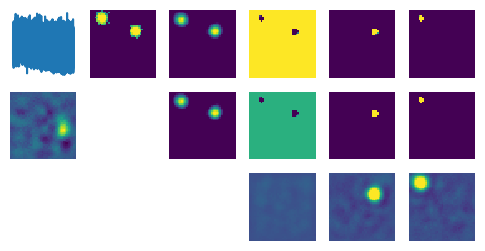

loss 38750 tensor(1.1370, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2467) >>><<
tensor(1.0000e-08) tensor(0.2467) >>><<
tensor(1.0000e-08) tensor(0.2467) >>><<


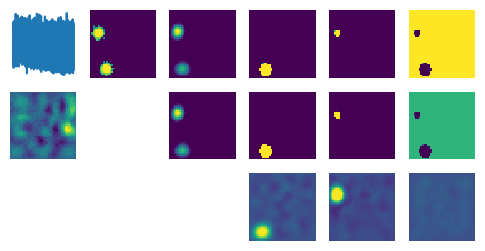

tensor(1.0000e-08) tensor(0.0801) >>><<
tensor(1.0000e-08) tensor(0.0801) >>><<
tensor(1.0000e-08) tensor(0.0801) >>><<


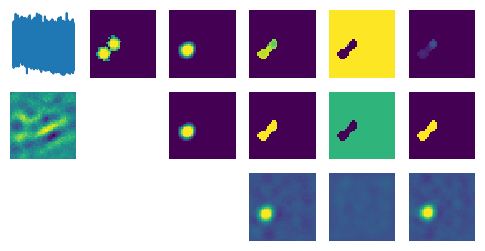

loss 39000 tensor(1.1777, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0870) >>><<
tensor(1.0000e-08) tensor(0.0870) >>><<
tensor(1.0000e-08) tensor(0.0870) >>><<


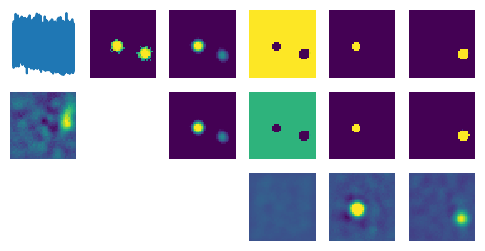

tensor(1.0000e-08) tensor(0.1145) >>><<
tensor(1.0000e-08) tensor(0.1145) >>><<
tensor(1.0000e-08) tensor(0.1145) >>><<


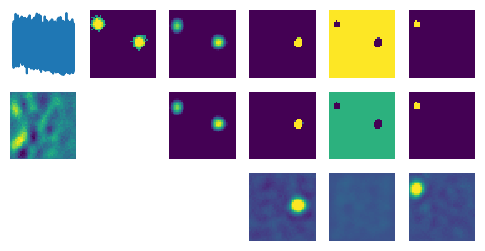

loss 39250 tensor(0.8399, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1291) >>><<
tensor(1.0000e-08) tensor(0.1291) >>><<
tensor(1.0000e-08) tensor(0.1291) >>><<


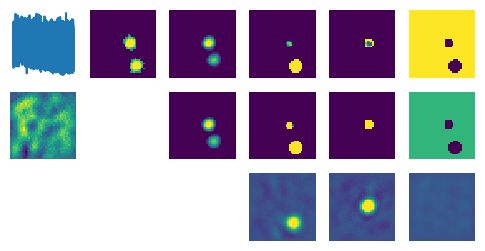

tensor(1.0000e-08) tensor(0.0714) >>><<
tensor(1.0000e-08) tensor(0.0714) >>><<
tensor(1.0000e-08) tensor(0.0714) >>><<


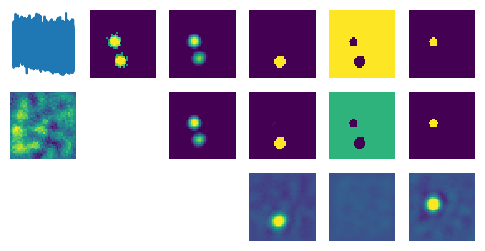

loss 39500 tensor(1.4958, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2153) >>><<
tensor(1.0000e-08) tensor(0.2153) >>><<
tensor(1.0000e-08) tensor(0.2153) >>><<


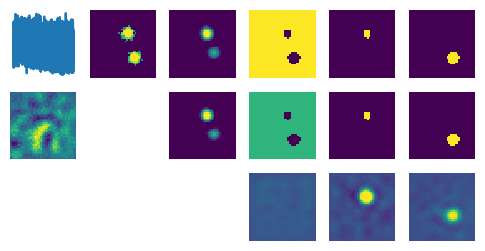

tensor(1.0000e-08) tensor(0.1443) >>><<
tensor(1.0000e-08) tensor(0.1443) >>><<
tensor(1.0000e-08) tensor(0.1443) >>><<


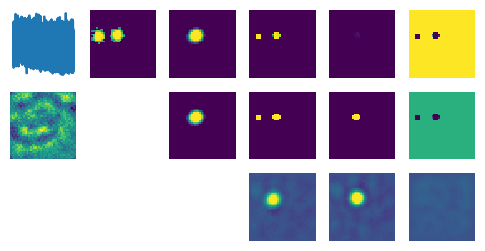

loss 39750 tensor(1.2437, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4272) >>><<
tensor(1.0000e-08) tensor(0.4272) >>><<
tensor(1.0000e-08) tensor(0.4272) >>><<


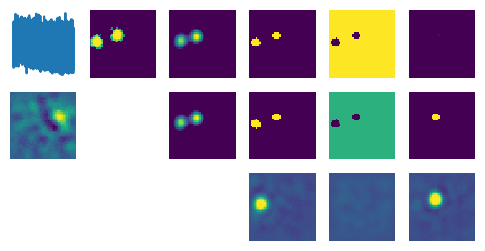

tensor(1.0000e-08) tensor(0.4107) >>><<
tensor(1.0000e-08) tensor(0.4107) >>><<
tensor(1.0000e-08) tensor(0.4107) >>><<


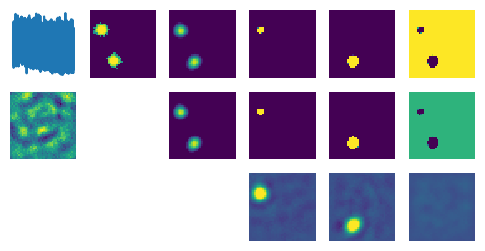

In [10]:
# model = AttModel()
model,*_rest = train(model,40_000)

In [658]:
# all-track fit :  is it a compromise just to make 

In [ ]:
!